#Data Overview

# Dataset Selection & Description:
The selected dataset is the Amazon Books Reviews dataset, containing approximately 3 million reviews from users on 212,000 unique books. Each record includes a user ID, book ID, rating score, review text, and summary, along with metadata such as title, authors, publisher, publication date, categories, and ratings count. Optional fields include book description, image link, and preview link.

The dataset comprises 19 features spanning categorical, numerical, and textual data types, making it well-suited for advanced analytics including classification, clustering, text/sentiment analysis, recommendation systems, and graph-based user-book interactions.

We initially loaded the dataset in Parquet format using Apache Spark, examined its schema, and assessed missing values. After filtering out incomplete rows based on key features, we retained a clean subset of over 1.1 million reviews for analysis


## Loading the Dataset



In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder \
        .master("local[48]") \
       .config("spark.driver.memory", "126g") \
       .config("spark.executor.instances", "6") \
       .config("spark.executor.cores", "7") \
       .config("spark.executor.memory", "126g") \
       .config("spark.memory.fraction", "0.8") \
       .config("spark.memory.storageFraction", "0.2") \
       .config("spark.default.parallelism", "288") \
       .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
       .config("spark.kryoserializer.buffer.max", "128m") \
       .config("spark.driver.extraJavaOptions", "-Xss1024m") \
       .config("spark.executor.extraJavaOptions", "-Xss1024m") \
       .appName("test") \
       .getOrCreate()


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import *
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.clustering import KMeans
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# create Spark Session
spark = SparkSession.builder.appName('DataFrameApp').master('local').getOrCreate()

In [4]:
df = spark.read.parquet("amazon_books.parquet",inferSchema='True')

In [5]:
df.limit(100).toPandas()


,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,Id,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,$5 Dollar Menus for Two,None,None,None,None,None,None,None,None,NaN,0972432779,None,AOVKTRWGT79PA,"""C. R Vachio """"Chris Vachio""""""",20/20,3.0,1091664000,"Good, but with problems","It's a decent book, but I have two beefs with ..."
1,'Filming of Gone With the Wind',Companion publication to the Harry Ransom Cent...,['Steve Wilson'],http://books.google.com/books/content?id=lyXNB...,http://books.google.com/books?id=lyXNBAAAQBAJ&...,University of Texas Press,2014-09-01,http://books.google.com/books?id=lyXNBAAAQBAJ&...,['Performing Arts'],1.0,0865546215,31.43,A29G690AOJJI36,Janet M Smekar,20/23,5.0,965606400,A Gone With The Fan's Dream book,This book is a dream come true for any GWTW fa...
2,'Filming of Gone With the Wind',Companion publication to the Harry Ransom Cent...,['Steve Wilson'],http://books.google.com/books/content?id=lyXNB...,http://books.google.com/books?id=lyXNBAAAQBAJ&...,University of Texas Press,2014-09-01,http://books.google.com/books?id=lyXNBAAAQBAJ&...,['Performing Arts'],1.0,0865546215,31.43,A1DD15RXIXWENM,"""Anton Beat Riess """"Toni Riess""""""",3/3,5.0,1275436800,Great Making of Book of GWTW,"Wow, fantastic book with behind the camera pho..."
3,'Filming of Gone With the Wind',Companion publication to the Harry Ransom Cent...,['Steve Wilson'],http://books.google.com/books/content?id=lyXNB...,http://books.google.com/books?id=lyXNBAAAQBAJ&...,University of Texas Press,2014-09-01,http://books.google.com/books?id=lyXNBAAAQBAJ&...,['Performing Arts'],1.0,0865546215,31.43,A3H74VATDFHV7A,C. Widing,2/2,5.0,1334361600,Must have ook,"If you are Gone With The Wind fan, this is a m..."
4,'Filming of Gone With the Wind',Companion publication to the Harry Ransom Cent...,['Steve Wilson'],http://books.google.com/books/content?id=lyXNB...,http://books.google.com/books?id=lyXNBAAAQBAJ&...,University of Texas Press,2014-09-01,http://books.google.com/books?id=lyXNBAAAQBAJ&...,['Performing Arts'],1.0,0865546215,31.43,A3WBI64716RJA,"""Rocky Fjord """"Rocky Fjord""""""",0/0,1.0,1357516800,A Disappointment,Was hoping for all scenes to be depicted in or...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,(ESV) English Standard Version Large Print Bib...,"The ESV Study Bible, Large Print edition trans...",['Crossway Bibles'],http://books.google.com/books/content?id=vmvWn...,http://books.google.nl/books?id=vmvWngEACAAJ&d...,None,2014-07-31,http://books.google.nl/books?id=vmvWngEACAAJ&d...,['Bibles'],NaN,1581346581,None,A4FNMWXU0URFE,Alan,0/0,5.0,1302393600,The only book to change my life!!,This bible is really resourceful. It's not too...
96,(ESV) English Standard Version Large Print Bib...,"The ESV Study Bible, Large Print edition trans...",['Crossway Bibles'],http://books.google.com/books/content?id=vmvWn...,http://books.google.nl/books?id=vmvWngEACAAJ&d...,None,2014-07-31,http://books.google.nl/books?id=vmvWngEACAAJ&d...,['Bibles'],NaN,1581346581,None,ACFS5CCV93T4T,Lucy06,0/0,5.0,1302307200,Really nice ESV Bible.,I'm 22 never really studied the bible before a...
97,(ESV) English Standard Version Large Print Bib...,"The ESV Study Bible, Large Print edition trans...",['Crossway Bibles'],http://books.google.com/books/content?id=vmvWn...,http://books.google.nl/books?id=vmvWngEACAAJ&d...,None,2014-07-31,http://books.google.nl/books?id=vmvWngEACAAJ&d...,['Bibles'],NaN,1581346581,None,A2GOWGQGUCF0SK,RunGreg,0/0,5.0,1356652800,Amazing,Love this BibleIt's thin.It's durable.It's ESV...
98,(ESV) English Standard Version Large Print Bib...,"The ESV Study Bible, Large Print edition trans...",['Crossway Bibles'],http://books.google.com/books/content?id=vmvWn...,http://books.google.nl/books?id=vmvWngEACAAJ&d...,None,2014-07-31,http://books.google.nl/books?id=vmvWngEACAAJ&d...,['Bibles'],NaN,1581346581,None,A25

## Schema of the dataset & overview:
Showing the names of the variables and their type.

In [6]:
#df.printSchema()
#df.show(5)

In [7]:
#df.limit(100).toPandas()


##Dimensions of the dataset:

In [8]:
# Number of rows
num_rows = df.count()

# Number of columns
num_cols = len(df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 2990896
Number of columns: 19


## Description of the variables:

In [9]:
from pyspark.sql import Row

# List of variables with their descriptions
schema_info = [
    Row(Variable="Title", Description="Title of the book"),
    Row(Variable="description", Description="Short description or blurb about the book"),
    Row(Variable="authors", Description="List of author(s) of the book"),
    Row(Variable="image", Description="URL of the book cover image"),
    Row(Variable="previewLink", Description="Link to preview the book (e.g., Google Books)"),
    Row(Variable="publisher", Description="Publisher of the book"),
    Row(Variable="publishedDate", Description="Date the book was published"),
    Row(Variable="infoLink", Description="Link to more information about the book"),
    Row(Variable="categories", Description="Category or genre of the book (e.g., Fiction)"),
    Row(Variable="ratingsCount", Description="Number of users who have rated the book"),
    Row(Variable="Id", Description="The ID of the book (typically ISBN)"),
    Row(Variable="Price", Description="The price of the book"),
    Row(Variable="User_id", Description="ID of the user who rated the book"),
    Row(Variable="profileName", Description="Name of the user who submitted the review"),
    Row(Variable="review/helpfulness", Description="Helpfulness rating of the review (e.g., 2/3)"),
    Row(Variable="review/score", Description="Star rating given by the user (from 0 to 5)"),
    Row(Variable="review/time", Description="Timestamp when the review was posted"),
    Row(Variable="review/summary", Description="Short summary of the review"),
    Row(Variable="review/text", Description="Full text content of the review")
]

# DataFrame
schema_df = spark.createDataFrame(schema_info)


schema_df.show(truncate=False)


+------------------+---------------------------------------------+
|Variable          |Description                                  |
+------------------+---------------------------------------------+
|Title             |Title of the book                            |
|description       |Short description or blurb about the book    |
|authors           |List of author(s) of the book                |
|image             |URL of the book cover image                  |
|previewLink       |Link to preview the book (e.g., Google Books)|
|publisher         |Publisher of the book                        |
|publishedDate     |Date the book was published                  |
|infoLink          |Link to more information about the book      |
|categories        |Category or genre of the book (e.g., Fiction)|
|ratingsCount      |Number of users who have rated the book      |
|Id                |The ID of the book (typically ISBN)          |
|Price             |The price of the book                     

# Data Cleaning:


## Null Values
The null values in all columns are checked using .isNull()

In [10]:
# calculate how many missing values we have in each column
from pyspark.sql.functions import col, sum, when

print("Null values in each column:")
df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()




Null values in each column:
+-----+-----------+-------+------+-----------+---------+-------------+--------+----------+------------+---+-------+-------+-----------+------------------+------------+-----------+--------------+-----------+
|Title|description|authors| image|previewLink|publisher|publishedDate|infoLink|categories|ratingsCount| Id|  Price|User_id|profileName|review/helpfulness|review/score|review/time|review/summary|review/text|
+-----+-----------+-------+------+-----------+---------+-------------+--------+----------+------------+---+-------+-------+-----------+------------------+------------+-----------+--------------+-----------+
|    0|     636399| 389757|537295|     329835|   778839|       353784|  329835|    548854|     1354830|  0|2511709| 560517|     560616|                41|           3|          7|            44|         15|
+-----+-----------+-------+------+-----------+---------+-------------+--------+----------+------------+---+-------+-------+-----------+---------

In [11]:
# We will delete the Price column because we have over 2.5 million missing values i.e over 84% of the observations are missing
# Drop unnecessary columns like image, previewLink and infoLink.


df = df.drop("Price","image","previewLink","infoLink")

df.show()

+--------------------+--------------------+-------------------+--------------------+-------------+--------------------+------------+----------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|               Title|         description|            authors|           publisher|publishedDate|          categories|ratingsCount|        Id|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+--------------------+--------------------+-------------------+--------------------+-------------+--------------------+------------+----------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|$5 Dollar Menus f...|                NULL|               NULL|                NULL|         NULL|                NULL|        NULL|0972432779| AOVKTRWGT79PA|"C. R Vachio ""Ch...|             20/20|    

In [12]:
# we drop all observations with missing user_id first and check again the number of missing values in other features to decide whether to proceed into imputation or not

df = df.na.drop(subset=["User_id"])
# calculate how many NA values we have in each column
from pyspark.sql.functions import col, sum, when

print("Null values in each column:")
df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).toPandas()

Null values in each column:


,Title,description,authors,publisher,publishedDate,categories,ratingsCount,Id,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,0,522694,316421,639376,287719,450225,1114427,0,0,99,41,3,7,35,8


In [13]:
#Removing all missing values in variables with a low total number of missing values e.g <100 and retain missing values for variables with a large number of NAs.
df = df.na.drop(subset=["User_id","profileName","review/summary","review/text","review/helpfulness","review/time", "review/score"])

# calculate how many na values we have in each column
from pyspark.sql.functions import col, sum, when

print("Null values in each column:")
df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()


Null values in each column:
+-----+-----------+-------+---------+-------------+----------+------------+---+-------+-----------+------------------+------------+-----------+--------------+-----------+
|Title|description|authors|publisher|publishedDate|categories|ratingsCount| Id|User_id|profileName|review/helpfulness|review/score|review/time|review/summary|review/text|
+-----+-----------+-------+---------+-------------+----------+------------+---+-------+-----------+------------------+------------+-----------+--------------+-----------+
|    0|     522669| 316399|   639343|       287704|    450206|     1114371|  0|      0|          0|                 0|           0|          0|             0|          0|
+-----+-----------+-------+---------+-------------+----------+------------+---+-------+-----------+------------------+------------+-----------+--------------+-----------+



In [14]:
# Removing all missing values
df = df.na.drop(subset=["User_id","description","authors","publisher","publishedDate","ratingsCount","categories","profileName","review/summary","review/text","review/helpfulness","review/time"])

# calculate how many na values we have in each column
from pyspark.sql.functions import col, sum, when

print("Null values in each column:")
df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()

Null values in each column:
+-----+-----------+-------+---------+-------------+----------+------------+---+-------+-----------+------------------+------------+-----------+--------------+-----------+
|Title|description|authors|publisher|publishedDate|categories|ratingsCount| Id|User_id|profileName|review/helpfulness|review/score|review/time|review/summary|review/text|
+-----+-----------+-------+---------+-------------+----------+------------+---+-------+-----------+------------------+------------+-----------+--------------+-----------+
|    0|          0|      0|        0|            0|         0|           0|  0|      0|          0|                 0|           0|          0|             0|          0|
+-----+-----------+-------+---------+-------------+----------+------------+---+-------+-----------+------------------+------------+-----------+--------------+-----------+



In [15]:
#Dimensions of the dataset after removing all missing values:

num_rows = df.count()
num_cols = len(df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 1133871
Number of columns: 15


We still had over 1 million observations after removing the missing values; therefore, we decided to proceed with only the fully complete subset of the dataset. This approach allowed us to maintain a high-quality dataset without compromising the volume of data available for analysis. Since our advanced analytical tasks—such as classification analysis, sentiment analysis, recommendation systems, and potential graph analytics—require complete and reliable information for key features (e.g., review/text, review/score, User_id), this filtering step ensures robust and interpretable results while simplifying preprocessing and modeling.

## Duplicated Values

In [16]:
# Count total duplicate rows (rows that are completely identical)
duplicate_count = df.count() - df.dropDuplicates().count()

print(f"Number of duplicated rows: {duplicate_count}")

Number of duplicated rows: 2835


There are 2835 duplicated rows. These were removed to ensure data quality and avoid redundancy in analysis.

In [17]:
# Remove duplicate rows
df = df.dropDuplicates()

In [18]:
#Dimensions of the dataset after removing all missing values and duplicated rows:

num_rows = df.count()
num_cols = len(df.columns)

print(f"Number of unique rows without missing values : {num_rows}")
print(f"Number of columns: {num_cols}")

Number of unique rows without missing values : 1131036
Number of columns: 15


In [19]:
df.show()

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+------------+----------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|               Title|         description|             authors|           publisher|publishedDate|          categories|ratingsCount|        Id|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+------------+----------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|1,000 Places to S...|The world’s bests...|['Patricia Schultz']|  Workman Publishing|   2015-07-01|          ['Travel']|       507.0|0761104844|A31WE0G828ZWY5|       Eric J. Lyman|           326/345|

In [20]:
df.select("review/score").distinct().count()

971

In [21]:
df.select("review/score").distinct().show(30, truncate=False)

+-----------------------+
|review/score           |
+-----------------------+
| then e..."            |
|18/19                  |
|1.0                    |
|0/16                   |
|0/1                    |
| fantasy               |
| avid Disney lover     |
| picture ..."          |
| and con..."           |
|9/10                   |
|7/7                    |
| artist                |
|3/3                    |
|33/33                  |
|11/15                  |
|7/8                    |
|3/4                    |
|8/9                    |
|37/39                  |
|5/6                    |
|10/11                  |
|8/8                    |
| and puppy lover ex..."|
| mammal"""             |
| doer"""               |
|7/9                    |
| SHUT UP!!!"""         |
|fur-mom"""             |
| reader"""             |
| Geek God"""           |
+-----------------------+
only showing top 30 rows



## review/score feature cleaning

In [22]:
# Cleaning the review score column so that it contains only float type entries rounded to 2 d.p.
from pyspark.sql.functions import expr, col, round as spark_round

df = df.withColumn(
    "review_score_clean",
    spark_round(
        expr("""
            CASE
                WHEN `review/score` RLIKE '^[0-9]+/[0-9]+$' THEN
                    CAST(split(`review/score`, '/')[0] AS FLOAT) / CAST(split(`review/score`, '/')[1] AS FLOAT)
                WHEN `review/score` RLIKE '^[0-9]+(\\.[0-9]+)?%$' THEN
                    CAST(REPLACE(`review/score`, '%', '') AS FLOAT) / 100
                WHEN `review/score` RLIKE '^[0-9]+(\\.[0-9]+)?$' THEN
                    CAST(`review/score` AS FLOAT)
                ELSE NULL
            END
        """), 2  # round to 2 decimal places
    )
)


In [23]:
df.show()

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+------------+----------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+------------------+
|               Title|         description|             authors|           publisher|publishedDate|          categories|ratingsCount|        Id|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|review_score_clean|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+------------+----------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+------------------+
|1,000 Places to S...|The world’s bests...|['Patricia Schultz']|  Workman Publishing|   2015-07-01|          ['Travel']|       507.0|076110484

In [24]:
#Number of missing values in the reviw_score_clean
df.filter(col("review_score_clean").isNull()).count()

3248

In [25]:
#Removing rows with missing values in review_score_clean
df = df.filter(col("review_score_clean").isNotNull())
df.count()

1127788

In [26]:
# Unique values in review_score_clean
df.select(col("review_score_clean")).distinct().orderBy("review_score_clean").show()

+------------------+
|review_score_clean|
+------------------+
|               0.0|
|              0.02|
|              0.03|
|              0.04|
|              0.06|
|              0.07|
|              0.08|
|              0.09|
|               0.1|
|              0.11|
|              0.12|
|              0.13|
|              0.14|
|              0.15|
|              0.16|
|              0.17|
|              0.18|
|              0.19|
|               0.2|
|              0.21|
+------------------+
only showing top 20 rows



In [27]:
# Removing the rows with review_score=327
df.filter(col("review_score_clean") != 327).count()

1127785

In [28]:
# Replace the original "review/score" column with its clean version
df = df.drop("review/score").withColumnRenamed("review_score_clean", "review/score")

In [29]:
df.select("review/score").show()

+------------+
|review/score|
+------------+
|         4.0|
|         5.0|
|         4.0|
|         5.0|
|         3.0|
|         5.0|
|         1.0|
|         3.0|
|         1.0|
|         5.0|
|         4.0|
|         5.0|
|         3.0|
|         4.0|
|         5.0|
|         5.0|
|         5.0|
|         3.0|
|         5.0|
|         4.0|
+------------+
only showing top 20 rows



In [30]:
df.select("Id").distinct().count() # Number of unique ISBNs after removing duplicates and missing values.

43377

In [31]:
df.select(col("User_id")).distinct().count() # Number of unique User ids after removing duplicates and missing values.

533518

In [32]:
df.select("authors").distinct().count() # Number of unique authors after removing duplicates and missing values

26585

In [33]:
df.select(col("Title")).distinct().count() # Number of unique Titles after removing duplicates and missing values

40283

In [34]:
df.select("publisher").distinct().count() # Number of unique publishers after removing duplicates and missing values

4686

In [35]:
print("Number of unique values of ratingsCount columns:",df.select(col("ratingsCount")).distinct().count())
df.select("ratingsCount").distinct().orderBy("ratingsCount").show(20, truncate=False)

Number of unique values of ratingsCount columns: 454
+------------+
|ratingsCount|
+------------+
|1.0         |
|2.0         |
|3.0         |
|4.0         |
|5.0         |
|6.0         |
|7.0         |
|8.0         |
|9.0         |
|10.0        |
|11.0        |
|12.0        |
|13.0        |
|14.0        |
|15.0        |
|16.0        |
|17.0        |
|18.0        |
|19.0        |
|20.0        |
+------------+
only showing top 20 rows



In [36]:
from pyspark.sql.functions import col, round as spark_round

# We Converted ratingsCount to integer
df = df.withColumn("ratingsCount", col("ratingsCount").cast("int"))

### Cleaning the "authors", "categories" and "publisher" columns

In [37]:
from pyspark.sql.functions import regexp_replace, col, trim

# Clean authors, categories, and publisher
df = df.withColumn("authors_clean", trim(regexp_replace(col("authors"), r"[\[\]']", "")))
df = df.withColumn("categories_clean", trim(regexp_replace(col("categories"), r"[\[\]']", "")))
df = df.withColumn("publisher_clean", trim(regexp_replace(col("publisher"), r"[\[\]']", "")))
# Further clean quotes, trailing periods, and extra spaces
for col_name in ["categories_clean", "authors_clean", "publisher_clean"]:
    df = df.withColumn(
        col_name,
        trim(
            regexp_replace(
                regexp_replace(col(col_name), r'^"|"$', ""),  # remove leading/trailing quotes
                r'\.$', ""  # remove trailing periods
            )
        )
    )

# Replace original columns with cleaned versions
df = df.drop("authors", "categories", "publisher") \
       .withColumnRenamed("authors_clean", "authors") \
       .withColumnRenamed("categories_clean", "categories") \
       .withColumnRenamed("publisher_clean", "publisher") \
       

In [38]:
df.limit(100).toPandas()


,Title,description,publishedDate,ratingsCount,Id,User_id,profileName,review/helpfulness,review/time,review/summary,review/text,review/score,authors,categories,publisher
0,"1,000 Places to See Before You Die: A Traveler...",The world’s bestselling travel book is back in...,2015-07-01,507,0761104844,A31WE0G828ZWY5,Eric J. Lyman,326/345,1072224000,Not bad ... for a to-do list,"I was prepared to really dislike this book, if...",4.0,Patricia Schultz,Travel,Workman Publishing
1,1812: The Rivers of War,Eric Flint’s acclaimed 1634: The Galileo Affai...,2010-03-31,3,B000MWC3BA,A2VWX4T0DGWVCZ,A. L. Jones,5/5,1120953600,Worth not waiting for the paperback,It's a more low-key alternate history than Fli...,5.0,Eric Flint,Fiction,Del Rey
2,50 Things You're Not Supposed to Know,Ever feel like you’re being kept in the dark? ...,2004-11-01,4,0971394288,A2T47C5XF9FQI7,"""""""blissengine""""""",16/26,1078704000,Light on the unknown,"In his latest book, Russ Kick brings together ...",4.0,Russ Kick,Social Science,Red Wheel Weiser
3,A Brig of War,"In A Brig of War, Nathaniel Drinkwater is prom...",2001-05-25,2,0719540097,APM2YU1RVZ5Y7,Panda,0/0,1360713600,Naval History,"""Very solid and well written. Exceptional look...",5.0,Richard Woodman,Fiction,Rowman & Littlefield
4,A Caress of Twilight,"“I am Princess Meredith, heir to a throne—if I...",2008-12-18,40,B0001FZGIA,A1M5JC3NQ6CPN2,werepanther,1/2,1017273600,Wasn't what I expected,"I love LKH, I loved her ABVH sereies, I loved ...",3.0,Laurell K. Hamilton,Fiction,Ballantine Books
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Credit Repair (with CD-Rom),The Definitive Guide to Raising Your Credit Sc...,2008-05-01,1,0873377699,A26LD9FQHTM8ZH,OlyNomad,0/1,1313280000,Nolo Credit Repair: useful reference book,I didn't select this book because I have bad c...,4.0,Trevor Rhodes,Business & Economics,McGraw Hill Professional
96,Crime and Punishment (Penguin Classics),"This classic, begun as a novel concerned with ...",2003,1,B000FG14OK,A3OEECMCM2T4KQ,C. Middleton,1/1,1205280000,"A Complex Tale of Mind, Soul & Spiritual Redem...","""The protagonist of this famous tale, Raskolni...",5.0,"Fedor Mikhailovitch Dostoïevski, Fyodor Dostoy...",Fiction,Penguin UK
97,Crime and Punishment (Penguin Classics),"This classic, begun as a novel concerned with ...",2003,1,B000FG14OK,A3SFO2GSP5CVSM,"""Cosmoetica """"cosmoeticadotcom""""""",2/5,1222732800,"Good, but overrated","The novel is a very good one, and compared to ...",4.0,"Fedor Mikhailovitch Dostoïevski, Fyodor Dostoy...",Fiction,Penguin UK
98,Crime and Punishment (Penguin Classics),"This classic, begun as a novel concerned with ...",2003,1,B000FG14OK,A1LW3XGXYP98BW,Hank Peace,0/0,1316131200,Literary Masterpiece Exploring Conscience and ...,I first started this novel during my senior ye...,5.0,"Fedor Mikhailovitch Dostoïevski, Fyodor Dostoy...",Fiction,Penguin UK


# Feature Engineering

##**review/score**
##Creating **review/score_int** variable

In [39]:
from pyspark.sql.functions import round as spark_round, col

# Round review_score_clean to nearest integer
df = df.withColumn("review/score_int", spark_round(col("review/score")).cast("int"))


## **review/helpfulness**

## Creating **helpfulness_%** variable
 Changing the review/helpfulness column so that it contains only %s.

In [40]:
from pyspark.sql.functions import col, split, round as spark_round, regexp_replace, when, lit

# Split into helpful and total votes
df = df.withColumn("helpfulness_split", split(col("review/helpfulness"), "/"))
df = df.withColumn("helpful_votes", col("helpfulness_split").getItem(0).cast("float"))
df = df.withColumn("total_votes", col("helpfulness_split").getItem(1).cast("float"))

# Calculate percentage (handle % values, invalids, and division by zero)
df = df.withColumn(
    "review_helpfulness",
    when(col("total_votes").isNotNull() & (col("total_votes") > 0),
         spark_round((col("helpful_votes") / col("total_votes")) * 100, 1))
    .when(col("review/helpfulness").rlike("^[0-9]+(\\.[0-9]+)?%$"),
          regexp_replace(col("review/helpfulness"), "%", "").cast("float"))
    .otherwise(0.0)  # catch malformed values like "abc" or "n/a"
)

In [41]:
#The review_helpfulness should take values from 0-100 thus we check which values need to be removed
from pyspark.sql.functions import col
df.filter(col("review_helpfulness") > 100).count()
df = df.filter(col("review_helpfulness") <= 100)

In [42]:
# Drop the original 'review/helpfulness' and unessecary columns created above
df = df.drop("review/helpfulness","helpfulness_split","helpful_votes","total_votes")

## Creating **helpfulness_category** Variable
Now we create another column for the helpfulness_category having 3 levels (High, Medium, Low) based on the % of review_helpfulness

In [43]:
# 75 - 100	High:	Most people found this helpful (75%–100%), clearly valuable
# 40 - 75	Medium:	Mixed opinions (some helpful, some not),  decent info, maybe subjective
# 0 - 40	Low: Few people found it helpful, probably noisy, off-topic, or spam

from pyspark.sql.functions import when
df = df.withColumn(
    "helpfulness_category",
    when(col("review_helpfulness") >= 75, "High")
    .when(col("review_helpfulness") >= 40, "Medium")
    .otherwise("Low")
)
df.show()

+--------------------+--------------------+-------------+------------+----------+--------------+--------------------+-----------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+
|               Title|         description|publishedDate|ratingsCount|        Id|       User_id|         profileName|review/time|      review/summary|         review/text|review/score|             authors|          categories|           publisher|review/score_int|review_helpfulness|helpfulness_category|
+--------------------+--------------------+-------------+------------+----------+--------------+--------------------+-----------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+
|1,000 Places to S...|The world’s bests...|   2015-07-01|         507|0761104844|A31W

## **review/time**

## Creating  **review year**, **review_month** & **review_day** variables from **review/time**

In [44]:
from pyspark.sql.functions import from_unixtime, year, month, dayofmonth, col

# Convert Unix timestamp to readable timestamp format
df = df.withColumn("review_timestamp", from_unixtime(col("review/time")))

# Extract year from timestamp
df = df.withColumn("review_year", year(col("review_timestamp")))

# Extract month from timestamp
df = df.withColumn("review_month", month(col("review_timestamp")))

# Extract day of the month from timestamp
df = df.withColumn("review_day", dayofmonth(col("review_timestamp")))


df.select("review_timestamp", "review_year", "review_month", "review_day").show(10, truncate=False)

+-------------------+-----------+------------+----------+
|review_timestamp   |review_year|review_month|review_day|
+-------------------+-----------+------------+----------+
|2003-12-24 00:00:00|2003       |12          |24        |
|2005-07-10 00:00:00|2005       |7           |10        |
|2004-03-08 00:00:00|2004       |3           |8         |
|2013-02-13 00:00:00|2013       |2           |13        |
|2002-03-28 00:00:00|2002       |3           |28        |
|2001-10-08 00:00:00|2001       |10          |8         |
|2012-10-16 00:00:00|2012       |10          |16        |
|2005-09-11 00:00:00|2005       |9           |11        |
|2004-09-07 00:00:00|2004       |9           |7         |
|2006-11-08 00:00:00|2006       |11          |8         |
+-------------------+-----------+------------+----------+
only showing top 10 rows



In [45]:
#  Drop temporary timestamp columns no longer needed
df = df.drop("review/time","review_timestamp")

In [46]:
#df.printSchema()
df.show()

+--------------------+--------------------+-------------+------------+----------+--------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+-----------+------------+----------+
|               Title|         description|publishedDate|ratingsCount|        Id|       User_id|         profileName|      review/summary|         review/text|review/score|             authors|          categories|           publisher|review/score_int|review_helpfulness|helpfulness_category|review_year|review_month|review_day|
+--------------------+--------------------+-------------+------------+----------+--------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+-----------+------------+----------+
|1,000 Places

In [47]:
# calculate how many na values we have in each column
from pyspark.sql.functions import col, sum, when

print("Null values in each column:")
df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()

Null values in each column:
+-----+-----------+-------------+------------+---+-------+-----------+--------------+-----------+------------+-------+----------+---------+----------------+------------------+--------------------+-----------+------------+----------+
|Title|description|publishedDate|ratingsCount| Id|User_id|profileName|review/summary|review/text|review/score|authors|categories|publisher|review/score_int|review_helpfulness|helpfulness_category|review_year|review_month|review_day|
+-----+-----------+-------------+------------+---+-------+-----------+--------------+-----------+------------+-------+----------+---------+----------------+------------------+--------------------+-----------+------------+----------+
|    0|          0|            0|           0|  0|      0|          0|             0|          0|           0|      0|         0|        0|               0|                 0|                   0|          3|           3|         3|
+-----+-----------+-------------+-------

In [48]:
# Drop rows with missing values in key review-related columns
df = df.na.drop(subset=["review_year", "review_month", "review_day"])

We removed rows with missing values in the review/helpfulness, review_year, review_month, and review_day columns to keep the dataset clean and reliable for analysis. Even though many values were missing in review_helpfulness_percent, we chose to drop them to avoid using incomplete or misleading information in our models.

## **categories** ,**authors** & **publisher**

## Turning the entries of  **categories**, **authors** & **publisher** variables into lists

In [49]:
from pyspark.sql.functions import split

df = df.withColumn("categories", split(col("categories"), ",\\s*"))
df = df.withColumn("authors", split(col("authors"), ",\\s*"))
df = df.withColumn("publisher", split(col("publisher"), ",\\s*"))

In [50]:
#len(df.columns)

In [51]:
from pyspark.sql.functions import col

# At least 2 publishers
print("Books with ≥ 2 publishers:", df.filter(col("publisher")[1].isNotNull()).count())

# At least 2 authors
print("Books with ≥ 2 authors:", df.filter(col("authors")[1].isNotNull()).count(),".Also there are books that have up to 6 authors")

# At least 2 categories
print("Books with ≥ 2 categories:", df.filter(col("categories")[1].isNotNull()).count(),".Also there are books that have up to 4 categories.")

Books with ≥ 2 publishers: 64645
Books with ≥ 2 authors: 111455 .Also there are books that have up to 6 authors
Books with ≥ 2 categories: 16024 .Also there are books that have up to 4 categories.


## Creating **primary_category** ,**primary_author** & **primary_publisher** variables

In [52]:
from pyspark.sql.functions import col

# Extract first item from the lists
df = df.withColumn("primary_author", col("authors").getItem(0))
df = df.withColumn("primary_category", col("categories").getItem(0))
df = df.withColumn("primary_publisher", col("publisher").getItem(0))

In [53]:
# calculate how many na values we have in each column
from pyspark.sql.functions import col, sum, when

print("Null values in each column:")
df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()

Null values in each column:
+-----+-----------+-------------+------------+---+-------+-----------+--------------+-----------+------------+-------+----------+---------+----------------+------------------+--------------------+-----------+------------+----------+--------------+----------------+-----------------+
|Title|description|publishedDate|ratingsCount| Id|User_id|profileName|review/summary|review/text|review/score|authors|categories|publisher|review/score_int|review_helpfulness|helpfulness_category|review_year|review_month|review_day|primary_author|primary_category|primary_publisher|
+-----+-----------+-------------+------------+---+-------+-----------+--------------+-----------+------------+-------+----------+---------+----------------+------------------+--------------------+-----------+------------+----------+--------------+----------------+-----------------+
|    0|          0|            0|           0|  0|      0|          0|             0|          0|           0|      0|     

## **review/text** , **review/summary** & **description**

# Clean & Normalize Text for Sentiment Analysis (including feature engineering)

In [54]:
from pyspark.sql.functions import col, lower, regexp_replace, trim
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# Clean raw text (lowercase + remove punctuation + trim)
df = df.withColumn("review/text", trim(regexp_replace(lower(col("review/text")), "[^a-zA-Z0-9\s]", "")))
df = df.withColumn("review/summary", trim(regexp_replace(lower(col("review/summary")), "[^a-zA-Z0-9\s]", "")))
df = df.withColumn("description", trim(regexp_replace(lower(col("description")), "[^a-zA-Z0-9\s]", "")))
df = df.withColumn("Title", trim(regexp_replace(lower(col("Title")), "[^a-zA-Z0-9\s]", "")))

In [55]:
# Tokenize (split text into words)
tokenizer_text = Tokenizer(inputCol="review/text", outputCol="review_text_tokens")
tokenizer_summary = Tokenizer(inputCol="review/summary", outputCol="review_summary_tokens")
tokenizer_description = Tokenizer(inputCol="description", outputCol="description_tokens")
tokenizer_title = Tokenizer(inputCol="Title", outputCol="title_tokens")



In [56]:
# Check if the column already exists before applying the transformation
if "review_text_tokens" not in df.columns:
    df = tokenizer_text.transform(df)
if "review_summary_tokens" not in df.columns:
    df = tokenizer_summary.transform(df)
if "description_tokens" not in df.columns:
    df = tokenizer_description.transform(df)
if "title_tokens" not in df.columns:
    df = tokenizer_title.transform(df)






In [57]:
# Remove stopwords
remover = StopWordsRemover(inputCol="review_text_tokens", outputCol="review_text_final")
df = remover.transform(df)

remover2 = StopWordsRemover(inputCol="review_summary_tokens", outputCol="review_summary_final")
df = remover2.transform(df)

remover3 = StopWordsRemover(inputCol="description_tokens", outputCol="description_final")
df = remover3.transform(df)

remover4 = StopWordsRemover(inputCol="title_tokens", outputCol="title_final")
df = remover4.transform(df)



In [58]:
#df.select("review_text_clean", "review_text_final").show(5, truncate=False)

# Lemmatization Review_Text_Final

In [59]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [60]:
# Define Lemmatizer UDF in PySpark
from nltk.stem import WordNetLemmatizer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

lemmatizer = WordNetLemmatizer()

# Define a lemmatization function
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens if len(token) > 2]

# Register it as a PySpark UDF
lemmer_udf = udf(lemmatize_tokens, ArrayType(StringType()))

In [61]:
# Apply to review_text_final
df = df.withColumn("review_text_lemmatized", lemmer_udf(df["review_text_final"]))

In [62]:
df.select("review_text_final", "review_text_lemmatized").limit(1000).toPandas()




,review_text_final,review_text_lemmatized
0,"[prepared, really, dislike, book, reason, take...","[prepared, really, dislike, book, reason, take..."
1,"[lowkey, alternate, history, flint, previously...","[lowkey, alternate, history, flint, previously..."
2,"[latest, book, russ, kick, brings, together, l...","[latest, book, rus, kick, brings, together, li..."
3,"[solid, well, written, exceptional, look, nels...","[solid, well, written, exceptional, look, nels..."
4,"[love, lkh, loved, abvh, sereies, loved, kiss,...","[love, lkh, loved, abvh, sereies, loved, kiss,..."
...,...,...
995,"[indian, captive, story, make, great, gift, op...","[indian, captive, story, make, great, gift, op..."
996,"[loved, stories, people, since, child, 40, sti...","[loved, story, people, since, child, still, la..."
997,"[say, abridged, kidding, seems, abridged, 90, ...","[say, abridged, kidding, seems, abridged, orig..."
998,"[love, story, detailed, beautiful, side, anne,...","[love, story, detailed, beautiful, side, anne,..."


## Creating a **review_text_len** Variable

In [63]:
#Text Length Analysis
from pyspark.sql.functions import length

# Length of review text
df = df.withColumn("review_text_len", length(col("review/text")))


In [64]:
df.show()

+--------------------+--------------------+-------------+------------+----------+--------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+-----------+------------+----------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------+
|               Title|         description|publishedDate|ratingsCount|        Id|       User_id|         profileName|      review/summary|         review/text|review/score|             authors|          categories|           publisher|review/score_int|review_helpfulness|helpfulness_category|review_year|review_month|review_day|      primary_author|    primary_category|   primary_publisher|  review_

In [65]:
# calculate how many na values we have in each column
#from pyspark.sql.functions import col, sum, when

#print("Null values in each column:")
#df.select([
    #sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    #for c in df.columns
#]).show()

# EDA

### Summary Statistics of Numeric Variables

In [66]:
# Get basic numeric summaries for key columns
df.select(
    "review/score",
    "review_helpfulness",
    "ratingsCount",
    "review_text_len"
).describe().show()


+-------+------------------+------------------+-----------------+-----------------+
|summary|      review/score|review_helpfulness|     ratingsCount|  review_text_len|
+-------+------------------+------------------+-----------------+-----------------+
|  count|           1127782|           1127782|          1127782|          1127782|
|   mean| 4.197122112252192| 47.96690486281924|286.0953074264352|613.5744505587072|
| stddev|1.2039265129831938| 42.76224223671617|822.8277751483515|641.5241948703805|
|    min|               0.0|               0.0|                1|                0|
|    max|               5.0|             100.0|             4895|            31745|
+-------+------------------+------------------+-----------------+-----------------+



# Univariate Analysis
## Numerical Variables

### Distributions of Numerical variables

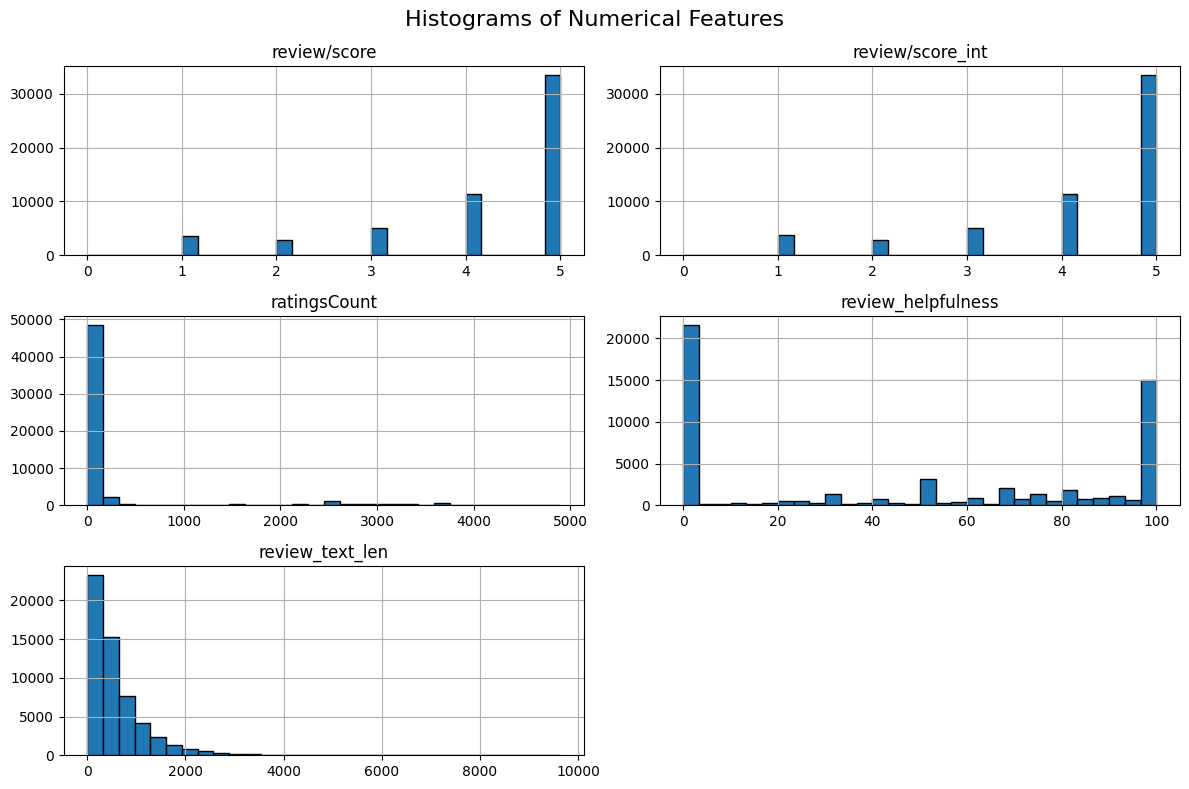

In [67]:
import matplotlib.pyplot as plt

# Select and sample numerical features
numerical_cols = ["review/score", "review/score_int","ratingsCount", "review_helpfulness", "review_text_len"]
pdf = df.select(*numerical_cols).sample(fraction=0.05, seed=42).toPandas()

# Plot 
pdf.hist(bins=30, figsize=(12, 8), color='#1f77b4', edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

#### review/score and review/score_int
These distributions are highly right-skewed. The majority of reviews have a score of 5, followed by 4. Very few reviews are rated 1, 2, or 3.
There is a clear positive bias in the rating system. Most users leave high ratings, which is common in product or book reviews. This skewness could affect modeling outcomes and may require balancing or normalization techniques.

#### ratingsCount
The distribution is extremely right-skewed. Most books have a very low number of ratings, but a few have thousands.
This follows a power-law distribution, where a small number of books are very popular and receive most of the attention.

#### review_helpfulness
The distribution appears bimodal or U-shaped. A large number of reviews have a helpfulness score of 0, and another large group has a score near 100.
Many reviews are either not rated as helpful at all or are rated as very helpful. This could be due to visibility bias, where widely viewed reviews tend to accumulate more helpfulness votes.

#### review_text_len
This feature is also right-skewed. Most reviews are short, typically under 1,000 characters, but there are some very long reviews.
Users tend to write short reviews, but a minority write long, detailed ones. These longer reviews might correlate with higher helpfulness scores or more polarized sentiments.

### review/score Distribution

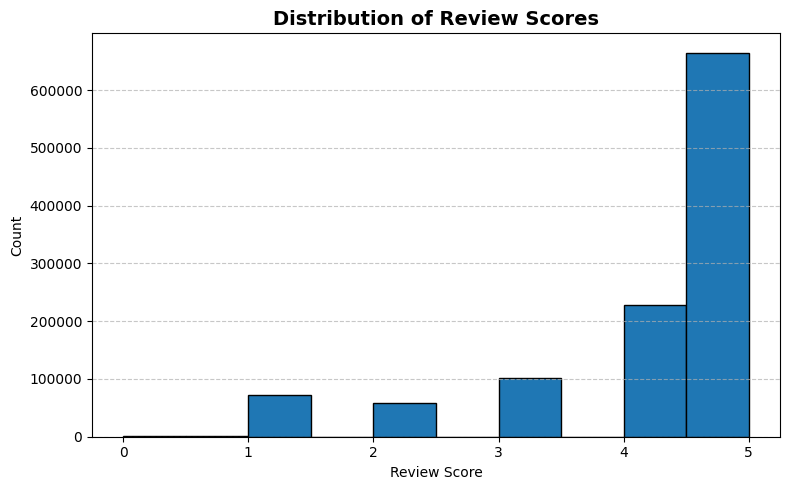

In [68]:
import matplotlib.pyplot as plt

# We Converted review/score column to pandas
score_pdf = df.select("review/score").toPandas()

# Plot
plt.figure(figsize=(8, 5))
plt.hist(score_pdf["review/score"], edgecolor="black", color="#1f77b4")
plt.title("Distribution of Review Scores", fontsize=14, fontweight="bold")
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


The distribution is clearly skewed to the right, with most of the reviews having a score of 5. This is pretty typical in user-generated review data, since people are more likely to leave a review when they’re really happy with a product. However, this imbalance could affect how models learn from the data, so we might need to apply techniques like reweighting, resampling, or data transformation to deal with the bias.

### review_helpfulness Distribution

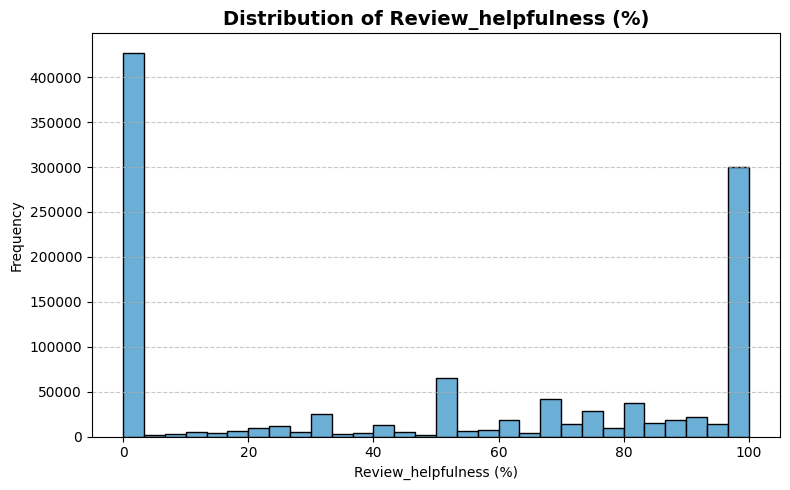

In [69]:
import matplotlib.pyplot as plt

# Convert to pandas
helpfulness_pd = df.select("review_helpfulness").toPandas()

# Plot 
plt.figure(figsize=(8, 5))
plt.hist(helpfulness_pd["review_helpfulness"], bins=30, color="#6baed6", edgecolor="black")
plt.title("Distribution of Review_helpfulness (%)", fontsize=14, fontweight="bold")
plt.xlabel("Review_helpfulness (%)")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


The distribution of review helpfulness percentages is clearly bimodal, with large peaks at 0% and 100%. This suggests that many reviews are either not rated as helpful at all or are considered very helpful by users, while the middle range is much less common.

## RatingsCount Distribution

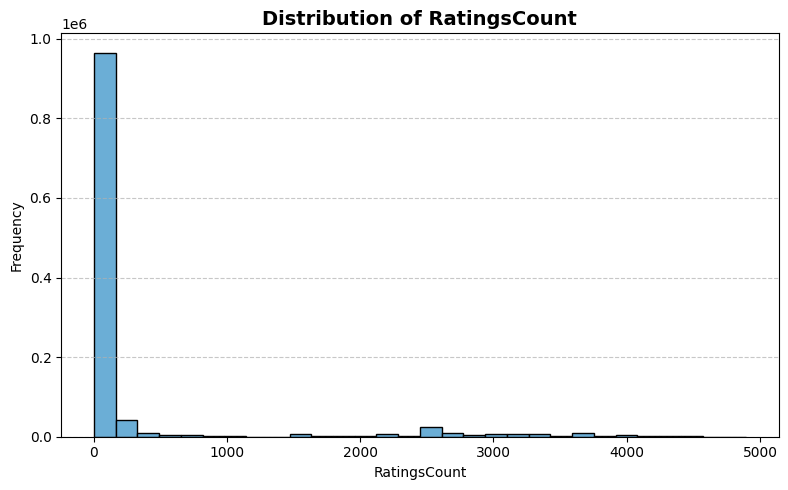

In [70]:
import matplotlib.pyplot as plt

# Convert to pandas
ratingsCount_pd = df.select("ratingsCount").toPandas()

# Plot 
plt.figure(figsize=(8, 5))
plt.hist(ratingsCount_pd["ratingsCount"], bins=30, color="#6baed6", edgecolor="black")
plt.title("Distribution of RatingsCount", fontsize=14, fontweight="bold")
plt.xlabel("RatingsCount")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


The majority of books are rarely rated, while a few popular ones receive a disproportionately high number of ratings. This imbalance suggests a long-tail distribution typical of user behavior in digital platforms.

# Univariate Analysis
## Categorical Variables

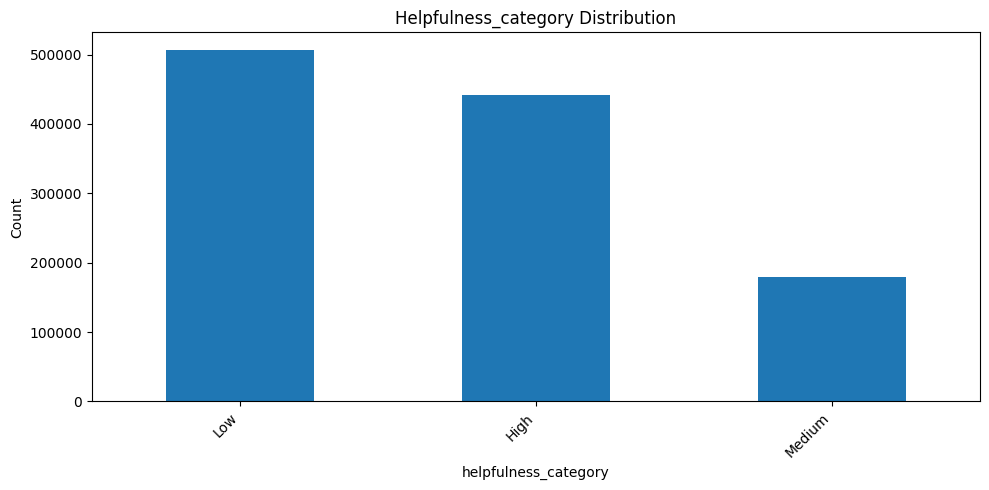

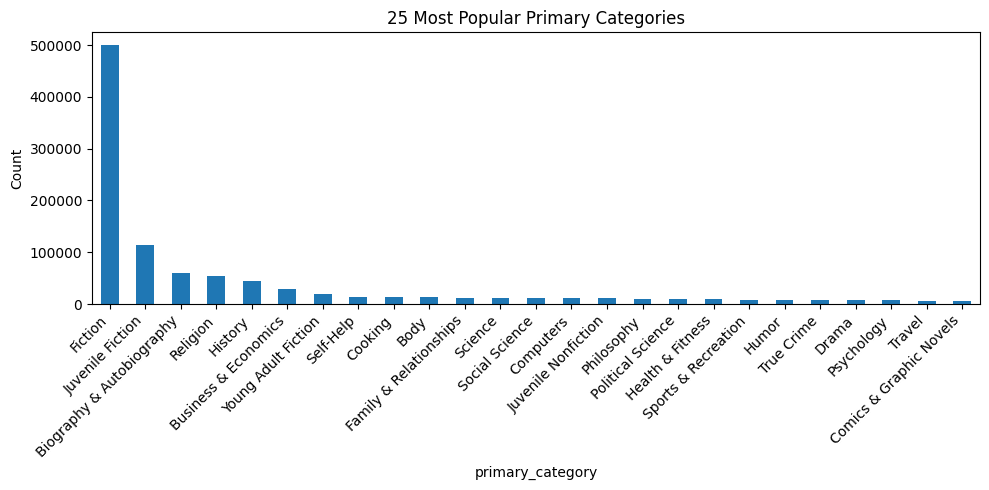

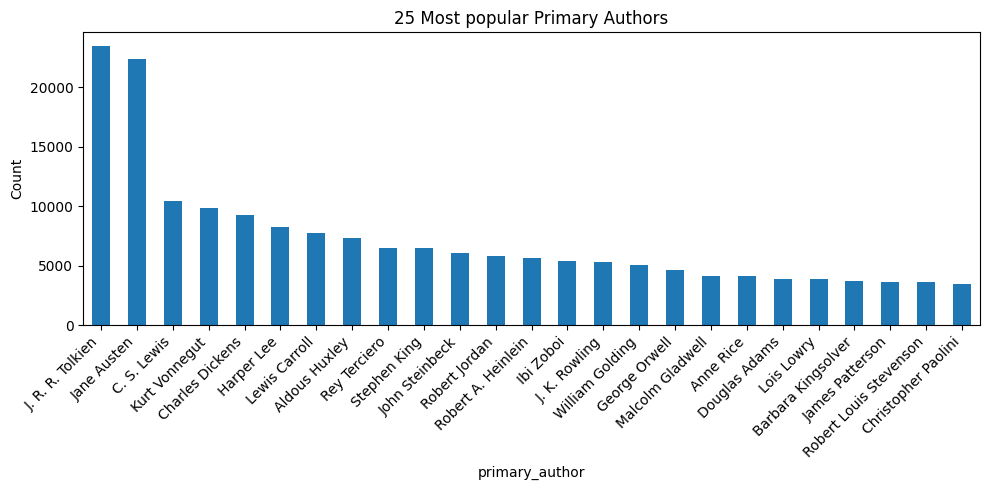

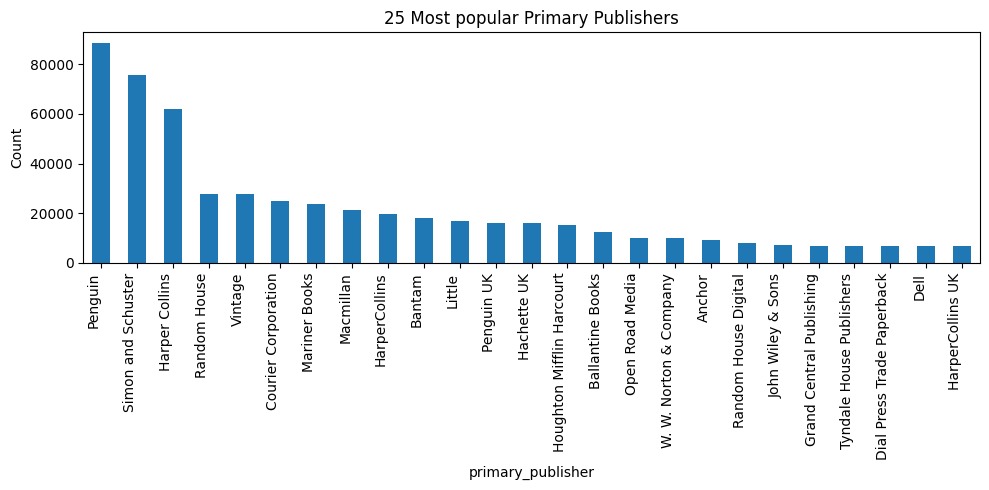

In [71]:
import matplotlib.pyplot as plt

# Helpfulness_category Distribution
ax = df.groupBy("helpfulness_category").count().orderBy("count", ascending=False).toPandas() \
  .plot(kind="bar", x="helpfulness_category", y="count", figsize=(10,5), title="Helpfulness_category Distribution", legend=False)
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 25 Most Popular Primary Categories
ax = df.groupBy("primary_category").count().orderBy("count", ascending=False).limit(25).toPandas() \
  .plot(kind="bar", x="primary_category", y="count", figsize=(10,5), title="25 Most Popular Primary Categories", legend=False)
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 25 Most Popular Primary Authors
ax = df.groupBy("primary_author").count().orderBy("count", ascending=False).limit(25).toPandas() \
  .plot(kind="bar", x="primary_author", y="count", figsize=(10,5), title="25 Most popular Primary Authors", legend=False)
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 25 Most Popular Primary Publishers
ax = df.groupBy("primary_publisher").count().orderBy("count", ascending=False).limit(25).toPandas() \
  .plot(kind="bar", x="primary_publisher", y="count", figsize=(10,5), title="25 Most popular Primary Publishers", legend=False)
ax.set_ylabel("Count")
plt.xticks( ha="right")
plt.tight_layout()
plt.show()


#### Helpfulness_category Distribution
The Low category has the highest count, indicating that a large portion of reviews were not marked as helpful by users.
The High category also has a substantial number of reviews, suggesting that many reviews were found very helpful.
The Medium category has the fewest reviews, showing that moderate helpfulness is less common.

#### 25 Most Popular Primary Categories
The bar chart displays the 25 most popular book categories based on review counts.
Fiction is by far the most reviewed category, with a count well above all others.
Juvenile Fiction comes next, followed by Biography & Autobiography, Religion, and History.
After the top few categories, the counts drop significantly, and the remaining categories have relatively similar and much lower review volumes.

#### 25 Most popular Primary Authors
The bar chart shows the 25 most popular primary authors based on the number of reviews in the dataset.
J. R. R. Tolkien and Jane Austen are the two most reviewed authors by a significant margin.
Other highly reviewed authors include C. S. Lewis, Kurt Vonnegut, and Charles Dickens.
After the top few authors, the number of reviews gradually declines, though the differences are not as sharp as in some other distributions.

#### 25 Most popular Primary Publishers
The bar chart shows the 25 most popular primary publishers based on review count.
Penguin, Simon and Schuster, and Harper Collins are the top three publishers, with Penguin leading by a large margin.
Other publishers like Random House, Vintage, and Courier Corporation also have significant review counts, though notably lower.
The distribution gradually decreases across the remaining publishers, forming a long tail.

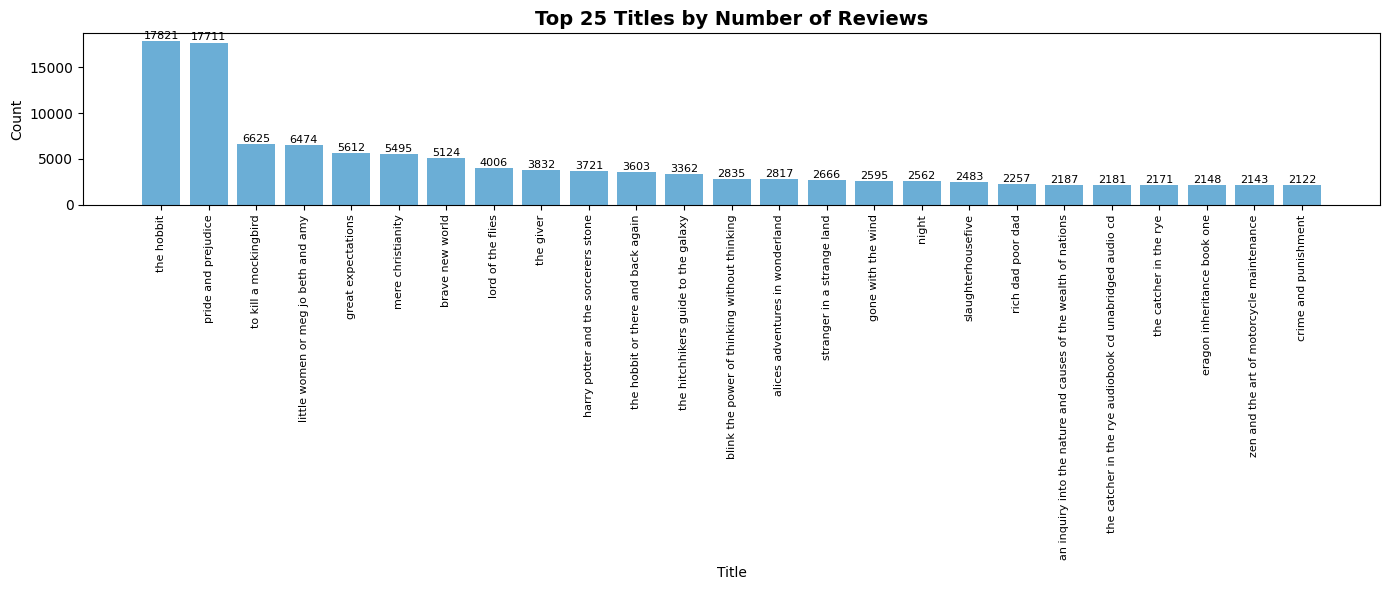

In [73]:
import matplotlib.pyplot as plt

# Get Top 25 Titles
title_df = df.groupBy("Title").count().orderBy("count", ascending=False).limit(25).toPandas()

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(title_df["Title"], title_df["count"], color="#6baed6")
plt.title("Top 25 Titles by Number of Reviews", fontsize=14, fontweight="bold")
plt.xlabel("Title")
plt.ylabel("Count")
plt.xticks(rotation=90, ha="center", fontsize=8)
plt.tight_layout()

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(int(height)),
             ha='center', va='bottom', fontsize=8)

plt.show()


A few classic and widely recognized books dominate in review volume, reflecting their enduring popularity and reader engagement. The remaining titles follow a long-tail distribution.

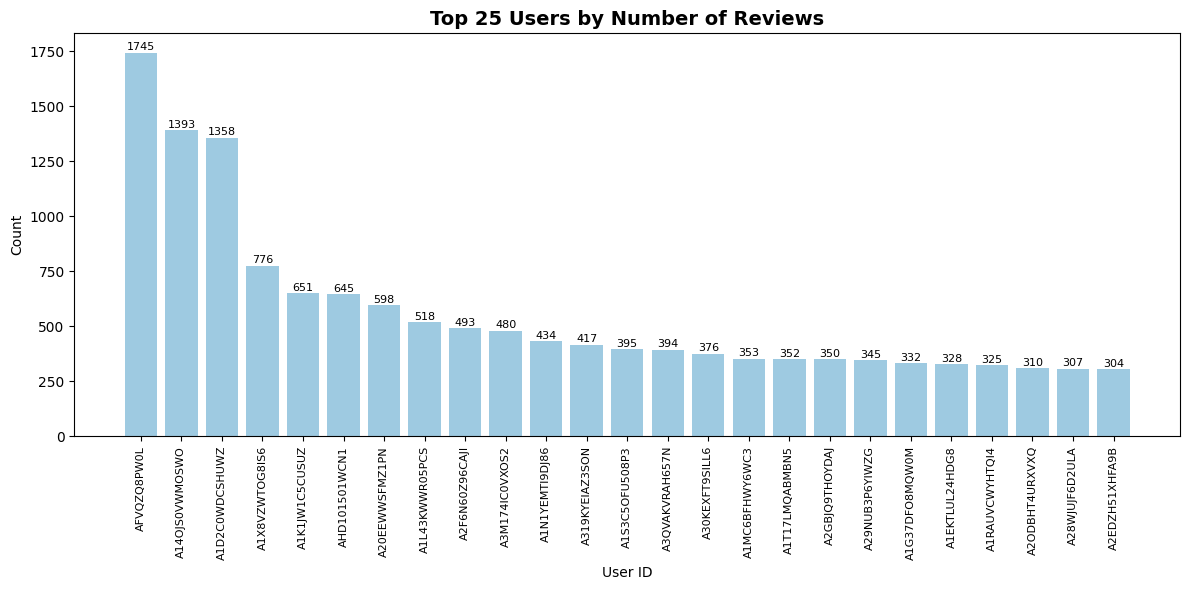

In [74]:
import matplotlib.pyplot as plt

# Get Top 25 User IDs
user_df = df.groupBy("User_id").count().orderBy("count", ascending=False).limit(25).toPandas()

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(user_df["User_id"], user_df["count"], color="#9ecae1")
plt.title("Top 25 Users by Number of Reviews", fontsize=14, fontweight="bold")
plt.xlabel("User ID")
plt.ylabel("Count")
plt.xticks(rotation=90, ha="center", fontsize=8)
plt.tight_layout()

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(int(height)),
             ha='center', va='bottom', fontsize=8)

plt.show()


A small group of highly active users contribute a large volume of reviews, highlighting the presence of power users in the dataset. This can have a strong influence on overall review patterns and system dynamics.

# Multivariate Analysis

In [72]:
# Correlation matrix (review/score, ratingsCount, review_helpfulness, review_text_len)

from pyspark.sql.functions import col
import pandas as pd

# Define the features
features = ["review/score", "ratingsCount", "review_helpfulness", "review_text_len"]

# Compute all pairwise correlations
corr_data = []
for i in features:
    row = []
    for j in features:
        row.append(round(df.stat.corr(i, j), 4))
    corr_data.append(row)

# Convert to pandas DataFrame
corr_df = pd.DataFrame(corr_data, columns=features, index=features)

# Display the matrix
print(corr_df)



                    review/score  ratingsCount  review_helpfulness  \
review/score              1.0000        0.0169              0.0584   
ratingsCount              0.0169        1.0000             -0.0575   
review_helpfulness        0.0584       -0.0575              1.0000   
review_text_len          -0.0363       -0.0128              0.2280   

                    review_text_len  
review/score                -0.0363  
ratingsCount                -0.0128  
review_helpfulness           0.2280  
review_text_len              1.0000  


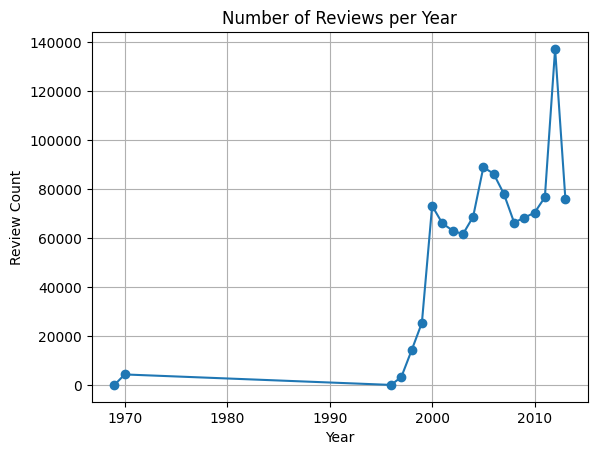

In [73]:
# Aggregate in Spark
year_counts = df.groupBy("review_year")\
    .count()\
    .orderBy("review_year")

# Collect to Python list
year_counts_list = year_counts.collect()

# Extract values into native Python lists
years = [row['review_year'] for row in year_counts_list]
counts = [row['count'] for row in year_counts_list]

# Plot using matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.plot(years, counts, marker='o')
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Review Count')
plt.grid(True)
plt.show()



Online review activity grew rapidly around the year 2000, peaked significantly in 2012, and then stabilized at a consistently high level, reflecting the expansion of digital platforms and user engagement.

In [74]:

from pyspark.sql.functions import split, explode # Corrected: changed explodemm to explode



# We Created temporary exploded DataFrame
category_counts = df.select(explode(col("categories")).alias("category")) \
                    .groupBy("category") \
                    .count() \
                    .orderBy(col("count").desc())

category_counts.show(50, truncate=False)

+---------------------------+------+
|category                   |count |
+---------------------------+------+
|Fiction                    |499681|
|Juvenile Fiction           |114647|
|Biography & Autobiography  |59478 |
|Religion                   |53479 |
|History                    |44941 |
|Business & Economics       |29611 |
|Young Adult Fiction        |19255 |
|Self-Help                  |13824 |
|Cooking                    |13097 |
|Body                       |12709 |
|Mind & Spirit              |12708 |
|Family & Relationships     |12549 |
|Science                    |12324 |
|Social Science             |11787 |
|Computers                  |11546 |
|Juvenile Nonfiction        |10780 |
|Philosophy                 |10469 |
|Political Science          |10344 |
|Health & Fitness           |10327 |
|Sports & Recreation        |8467  |
|Humor                      |8357  |
|True Crime                 |7690  |
|Drama                      |7517  |
|Psychology                 |7244  |
|

In [75]:
df.select("primary_category").distinct().count()

1078

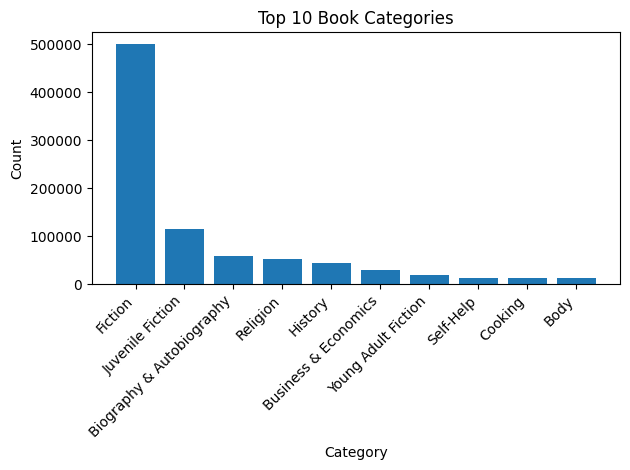

In [76]:

from pyspark.sql.functions import explode, col

top_cats = df.select(explode(col("categories")).alias("category")) \
    .groupBy("category") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(10) \
    .toPandas()

plt.figure()
plt.bar(top_cats['category'], top_cats['count'])
plt.title('Top 10 Book Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Fiction is by far the most popular category among reviewers, while other genres show moderate but much lower levels of engagement. The distribution follows a steep drop-off after the top few categories.

In [77]:
## Descriptive Trends

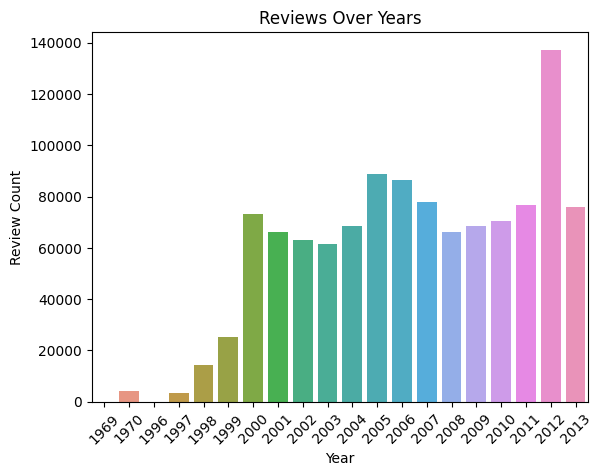

In [78]:
pdf = df.select("review_year").toPandas()

sns.countplot(x="review_year", data=pdf, order=sorted(pdf["review_year"].dropna().unique()))
plt.title("Reviews Over Years")
plt.xlabel("Year")
plt.ylabel("Review Count")
plt.xticks(rotation=45)
plt.show()

Review activity increased rapidly around the year 2000, peaked in 2012, and stayed consistently high, reflecting the growing popularity of online review platforms during that period.

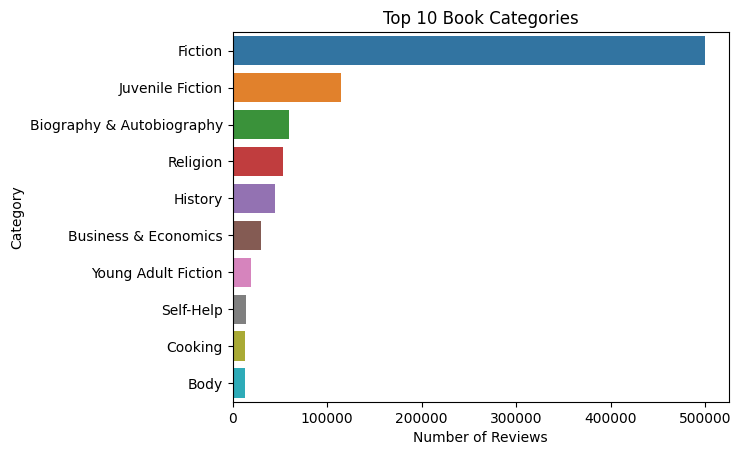

In [79]:
pdf = df.selectExpr("explode(categories) as category").toPandas() # Use "categories" instead of "categories_list"
top_categories = pdf["category"].value_counts().head(10)

sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title("Top 10 Book Categories")
plt.xlabel("Number of Reviews")
plt.ylabel("Category")
plt.show()

Fiction dominates user engagement in terms of reviews, while all other categories, even the next most popular ones, are far behind, indicating a strong concentration of interest in that genre.

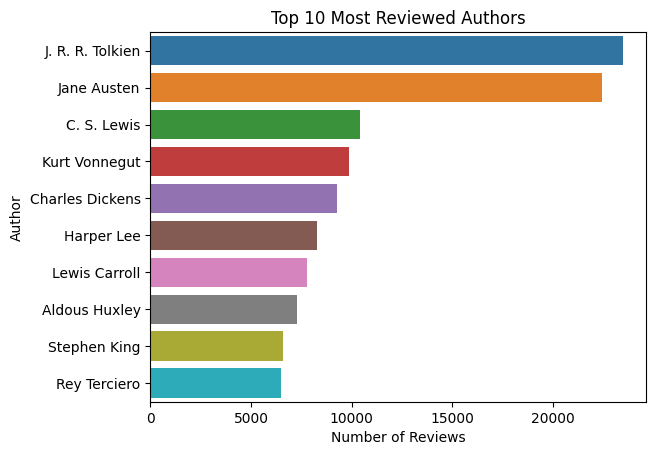

In [80]:
authors_pdf = df.selectExpr("explode(authors) as author").toPandas()

top_authors = authors_pdf["author"].value_counts().head(10)

sns.barplot(x=top_authors.values, y=top_authors.index)
plt.title("Top 10 Most Reviewed Authors")
plt.xlabel("Number of Reviews")
plt.ylabel("Author")
plt.show()

A few classic authors dominate the review volume, indicating strong and enduring reader interest in their works across time.

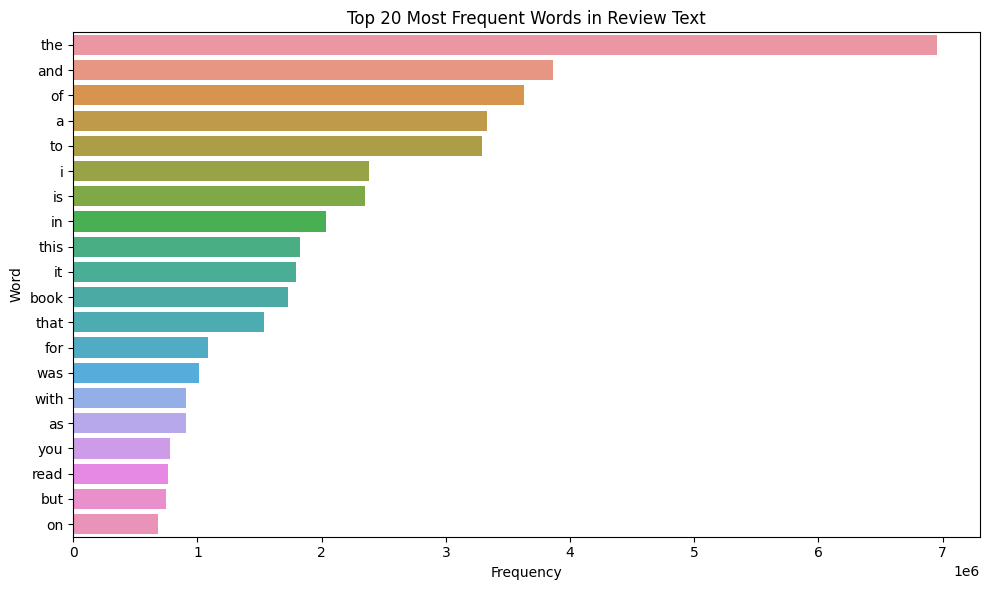

In [81]:
from pyspark.sql.functions import explode, col
import seaborn as sns
import matplotlib.pyplot as plt


tokens_df = df.select(explode(col("review_text_tokens")).alias("word"))

word_counts = tokens_df.groupBy("word").count().orderBy("count", ascending=False).limit(20)

top_words_pdf = word_counts.toPandas()

# Plot 
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="word", data=top_words_pdf)
plt.title("Top 20 Most Frequent Words in Review Text")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

Most of the top words are stop words, which are expected in unfiltered text. For meaningful text analysis or modeling, these would usually be removed to focus on more informative terms.

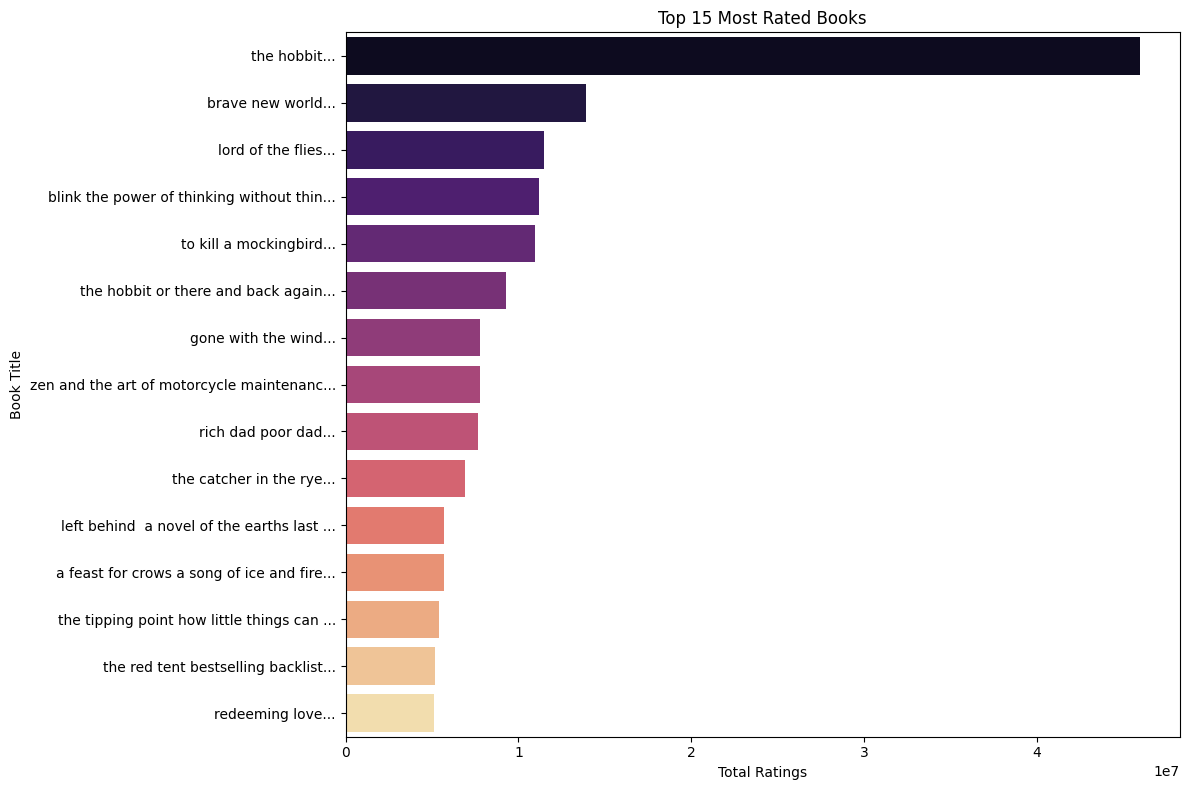

In [82]:
df.filter((col("ratingsCount").isNotNull()) & (col("ratingsCount") > 0)).count()

from pyspark.sql.functions import sum

top_books_df = df.filter(col("ratingsCount").isNotNull()) \
    .groupBy("Title") \
    .agg(sum("ratingsCount").alias("total_ratings")) \
    .orderBy(col("total_ratings").desc()) \
    .limit(15) \
    .toPandas()

top_books_df["short_title"] = top_books_df["Title"].str.slice(0, 40) + "..."

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x="total_ratings", y="short_title", data=top_books_df, palette="magma")
plt.title("Top 15 Most Rated Books")
plt.xlabel("Total Ratings")
plt.ylabel("Book Title")
plt.tight_layout()
plt.show()


A small number of classic and widely popular books dominate in rating volume, with "The Hobbit" leading by a large margin. This reflects both historical literary impact and sustained reader engagement over time.

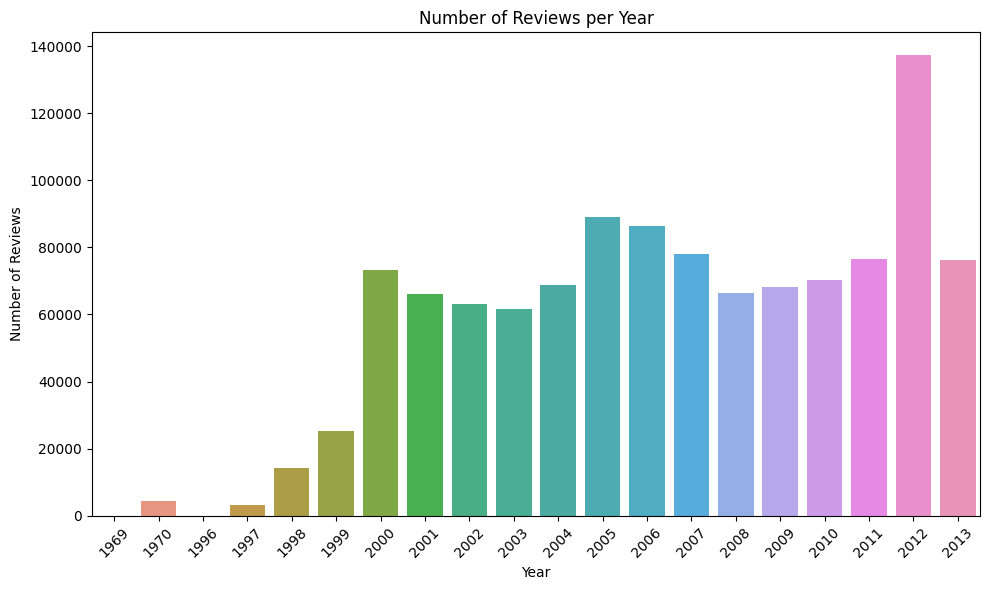

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count reviews per year in PySpark
df_yearly = df.groupBy("review_year").count().orderBy("review_year")

# Convert to Pandas for plotting
df_yearly_pd = df_yearly.toPandas()


plt.figure(figsize=(10, 6))
sns.barplot(x="review_year", y="count", data=df_yearly_pd)
plt.title("Number of Reviews per Year")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Online review activity increased sharply after the late 1990s, peaked in 2012, and maintained high levels, reflecting the rise of digital platforms and greater user participation in that era.

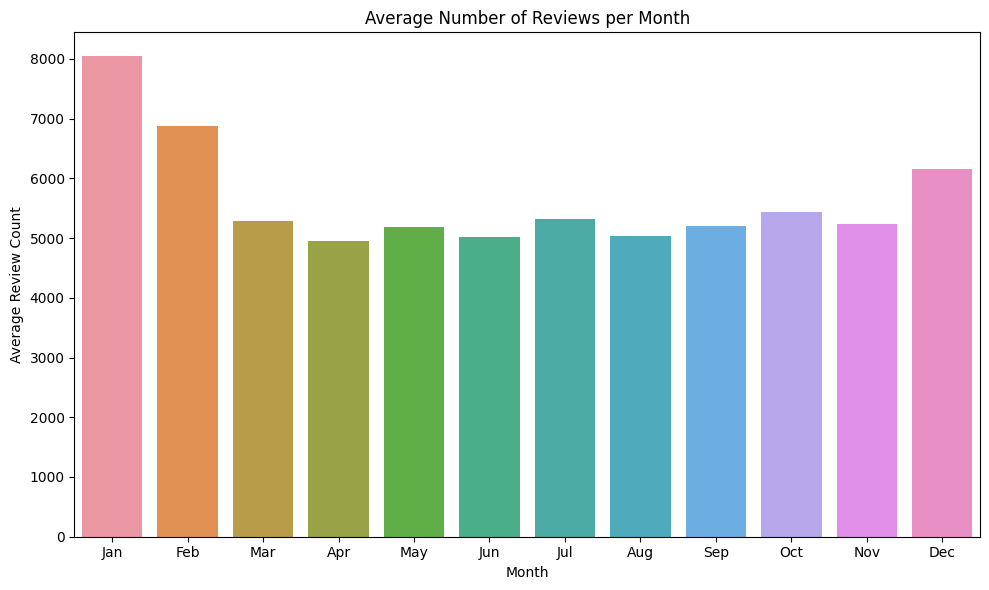

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract year and month, then count reviews per year-month
df_monthly = df.select("review_year", "review_month").dropna().toPandas()

# Group by year and month and count reviews
monthly_counts = df_monthly.groupby(["review_year", "review_month"]).size().reset_index(name="review_count")

# Average number of reviews per month 
avg_reviews_per_month = monthly_counts.groupby("review_month")["review_count"].mean()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_reviews_per_month.index.astype(int), y=avg_reviews_per_month.values)
plt.title("Average Number of Reviews per Month")
plt.xlabel("Month")
plt.ylabel("Average Review Count")
plt.xticks(ticks=range(0, 12), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
])
plt.tight_layout()
plt.show()

Review activity peaks in January and December, possibly due to holiday-related reading and gifting patterns, while the spring and summer months show a dip in user engagement.

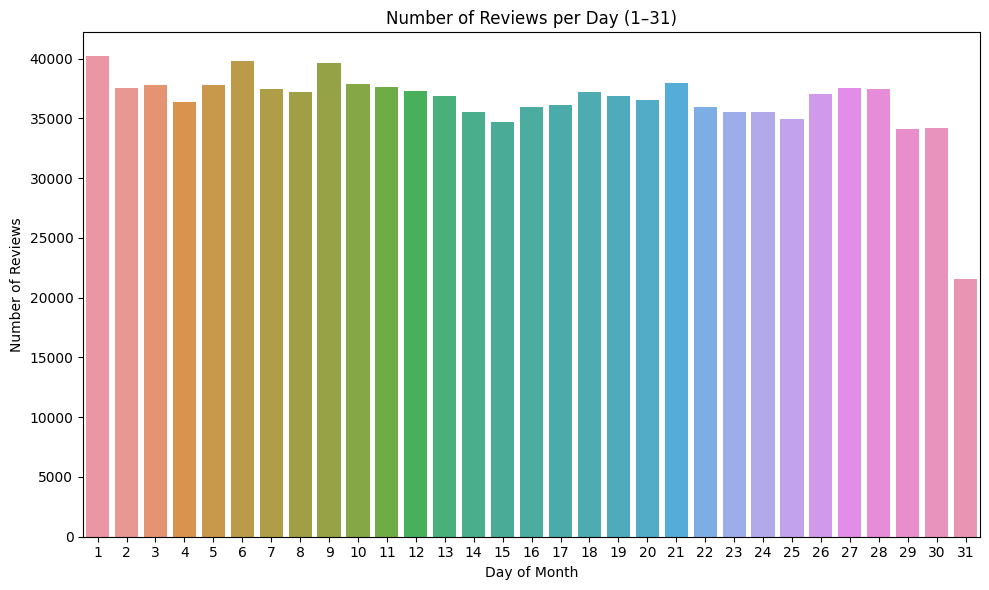

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract review day column as a Pandas DataFrame
df_daily = df.select("review_day").dropna().toPandas()

# Count reviews per day 
daily_counts = df_daily["review_day"].value_counts().sort_index()

# Plot 
plt.figure(figsize=(10, 6))
sns.barplot(x=daily_counts.index.astype(int), y=daily_counts.values)
plt.title("Number of Reviews per Day (1–31)")
plt.xlabel("Day of Month")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

User review activity is evenly distributed across the month, with slight peaks on the 1st and dips on the 31st due to calendar constraints.

In [86]:
from pyspark.sql.functions import explode, col, expr

# Explode authors array into individual author entries
df_exploded_authors = df.withColumn("author", explode(col("authors")))

# Compute average score and count per author
author_scores_df = df_exploded_authors.groupBy("author") \
    .agg(
        expr("avg(`review/score_int`) as avg_score"),
        expr("count(*) as review_count")
    ) \
    .filter("review_count >= 10") \
    .orderBy(col("avg_score").desc()) \
    .limit(25)

author_scores_df.show(truncate=False)

+--------------------------------------------------------------------------------+---------+------------+
|author                                                                          |avg_score|review_count|
+--------------------------------------------------------------------------------+---------+------------+
|Michelle Cole                                                                   |5.0      |106         |
|Heather Terrell                                                                 |5.0      |10          |
|Susi Hasel Mundy                                                                |5.0      |16          |
|Nicholas Rollin                                                                 |5.0      |13          |
|Henry Clay Trumbull                                                             |5.0      |72          |
|Tim Tebow                                                                       |5.0      |13          |
|Beatriz Galimberti Jarman                    

These authors consistently receive perfect review scores, indicating strong reader approval. However, their visibility varies, some have broad reach (high review count), while others may be more niche but highly appreciated by their readers.

In [87]:
from pyspark.sql.functions import explode, col, expr

# Explode the already-array column
df = df.withColumn("category", explode(col("categories")))

# Group and compute stats
category_scores_df = df.groupBy("category") \
    .agg(
        expr("avg(`review/score_int`) as avg_score"),
        expr("count(*) as review_count")
    ) \
    .filter("review_count >= 10") \
    .orderBy(col("avg_score").desc()) \
    .limit(25)

category_scores_df.show(truncate=False)

+------------------------------+------------------+------------+
|category                      |avg_score         |review_count|
+------------------------------+------------------+------------+
|Spiritual healing             |5.0               |11          |
|Birthdays                     |5.0               |18          |
|Attitude (Psychology)         |5.0               |11          |
|Iguana (Genus)                |4.9523809523809526|21          |
|Gangs                         |4.947368421052632 |19          |
|Autobiographies               |4.944444444444445 |18          |
|Fantastic fiction             |4.942857142857143 |35          |
|Pictorial                     |4.931034482758621 |58          |
|Ceramic sculpture             |4.923076923076923 |13          |
|Germany                       |4.916666666666667 |48          |
|Business cycles               |4.916666666666667 |12          |
|Accelerated readers           |4.916666666666667 |12          |
|Clouds                  

While niche categories dominate the very top in terms of average score, categories with a broader appeal still perform very well. This suggests both specialized and general interest areas can achieve high reader satisfaction when well-executed.

In [88]:
from pyspark.sql.functions import col, expr

# Group by publisher, calculate average review score and review count
publisher_scores_df = df.groupBy("publisher") \
    .agg(
        expr("avg(`review/score_int`) as avg_score"),
        expr("count(*) as review_count")
    ) \
    .filter("review_count >= 10") \
    .orderBy(col("avg_score").desc()) \
    .limit(25)

publisher_scores_df.show(truncate=False)


+--------------------------------------+---------+------------+
|publisher                             |avg_score|review_count|
+--------------------------------------+---------+------------+
|[Amagi Books]                         |5.0      |10          |
|[Snow Lion Publications, Incorporated]|5.0      |14          |
|[Warne]                               |5.0      |13          |
|[Centretruths Digital Media]          |5.0      |15          |
|[Image Connection]                    |5.0      |24          |
|[Middleway Press]                     |5.0      |22          |
|[Aspen Pub]                           |5.0      |10          |
|[New Knowledge Library]               |5.0      |58          |
|[Editora Dracaena]                    |5.0      |12          |
|[Stillpoint Pub]                      |5.0      |10          |
|[Fesler-Lampert Minnesota Herit]      |5.0      |14          |
|[Alexander (Hardcover)]               |5.0      |12          |
|[Pardey Books]                        |

While these publishers maintain perfect scores, the limited number of reviews suggests caution in interpreting these results as broadly representative. Still, it highlights strong reader appreciation for certain niche or specialized publishers.

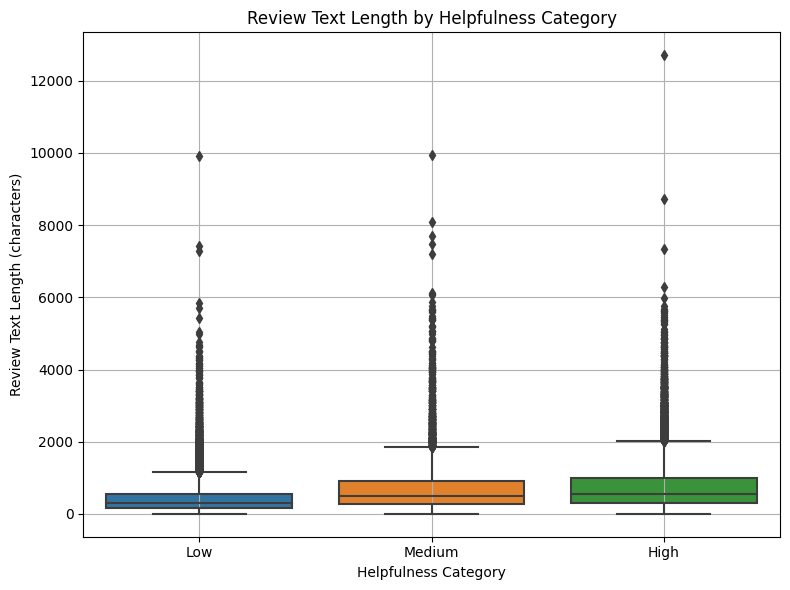

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select and convert the relevant columns to Pandas
help_len_pdf = df.select("review_text_len", "helpfulness_category") \
                 .dropna() \
                 .limit(50000) \
                 .toPandas()

# Plot boxplots
plt.figure(figsize=(8, 6))
sns.boxplot(x="helpfulness_category", y="review_text_len", data=help_len_pdf, order=["Low", "Medium", "High"])
plt.title("Review Text Length by Helpfulness Category")
plt.xlabel("Helpfulness Category")
plt.ylabel("Review Text Length (characters)")
plt.grid(True)
plt.tight_layout()
plt.show()

There is a positive association between review length and perceived helpfulness. In general, longer reviews are more likely to be marked as helpful by users.

## Sentiment **Analysis**

In [90]:
!pip install nltk
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [91]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

vader = SentimentIntensityAnalyzer()


In [92]:
# We defined a UDF (User-Defined Function) to calculate VADER compound sentiment score from tokenized text
def get_compound_score(tokens):
    # If tokens are in list format (already tokenized), join them into a sentence
    if isinstance(tokens, list):
        text = ' '.join(tokens)
    else:
        text = str(tokens)
    # We used VADER sentiment analyzer to get sentiment scores for the text
    score = vader.polarity_scores(text)
    # Returned the compound score as a float (range: -1 very negative to +1 very positive)
    return float(score['compound'])

# We registered the function as a Spark UDF that returns a FloatType
compound_udf = udf(get_compound_score, FloatType())

In [93]:
# Why We Use review_text_lemmatized Instead of review/text
# It’s cleaned and standardized,review_text_lemmatized has been processed to remove punctuation, stopwords, and irrelevant noise. It also includes lemmatization, reducing words to their base forms.

df = df.withColumn("compound", compound_udf("review_text_lemmatized"))

In [94]:
# We created and registered a UDF to classify sentiment
def classify_sentiment(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

sentiment_udf = udf(classify_sentiment, StringType())

In [95]:
df = df.withColumn("sentiment_label", sentiment_udf("compound"))


In [96]:
df.select("review_text_lemmatized", "compound", "sentiment_label").show(5, truncate=True)

+----------------------+--------+---------------+
|review_text_lemmatized|compound|sentiment_label|
+----------------------+--------+---------------+
|  [prepared, really...|  0.9951|       positive|
|  [lowkey, alternat...|  0.9583|       positive|
|  [latest, book, ru...|  0.8402|       positive|
|  [solid, well, wri...|  0.2023|       positive|
|  [love, lkh, loved...|  0.9906|       positive|
+----------------------+--------+---------------+
only showing top 5 rows



In [97]:
# We got counts of each sentiment label in Spark
sentiment_counts = df.groupBy("sentiment_label").count().limit(3).toPandas()

In [98]:
print(sentiment_counts)

  sentiment_label   count
0        positive  932362
1         neutral   43012
2        negative  168814


In [99]:
# We filtered compound values by sentiment class

df.cache()

positive = df.filter(df["compound"] > 0).select("compound").toPandas()["compound"]
negative = df.filter(df["compound"] < 0).select("compound").toPandas()["compound"]
neutral = df.filter(df["compound"] == 0).select("compound").toPandas()["compound"]


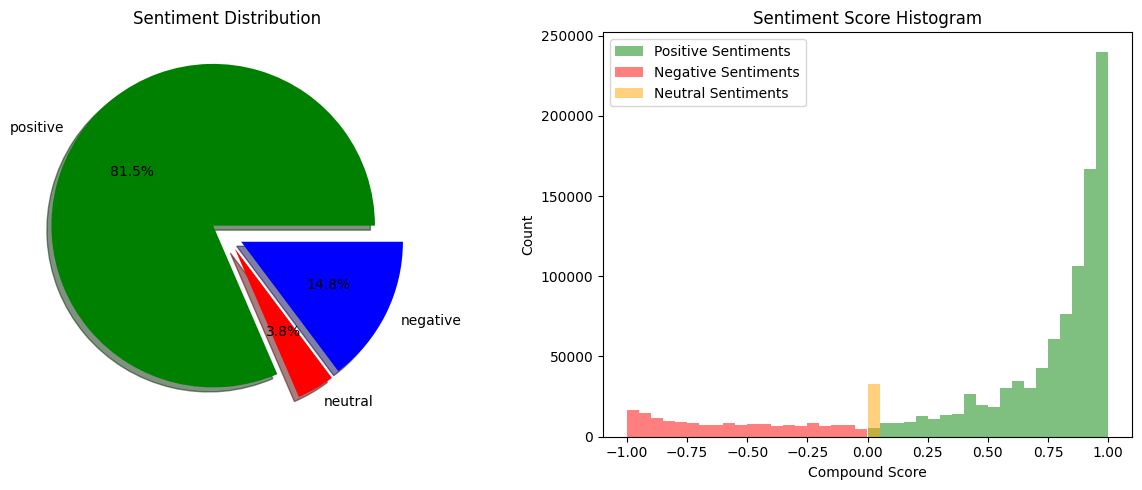

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Pie Chart
plt.subplot(1, 2, 1)
labels = sentiment_counts['sentiment_label']
sizes = sentiment_counts['count']
colors = ['green', 'red', 'blue']
explode = (0.1, 0.1, 0.1)

plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', shadow=True)
plt.title('Sentiment Distribution')

# Histogram
plt.subplot(1, 2, 2)
sentiments = [positive, negative, neutral]
colors = ['green', 'red', 'orange']
labels = ['Positive Sentiments', 'Negative Sentiments', 'Neutral Sentiments']

for sentiment, color, label in zip(sentiments, colors, labels):
    plt.hist(sentiment, bins=20, color=color, alpha=0.5, label=label)

plt.title('Sentiment Score Histogram')
plt.xlabel('Compound Score')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()



The pie chart shows class imbalance clearly (81% positive), which is very informative.

The histogram of compound scores adds depth to our analysis , most positives are strongly positive (clustered near 1.0), which supports the pie chart visually.

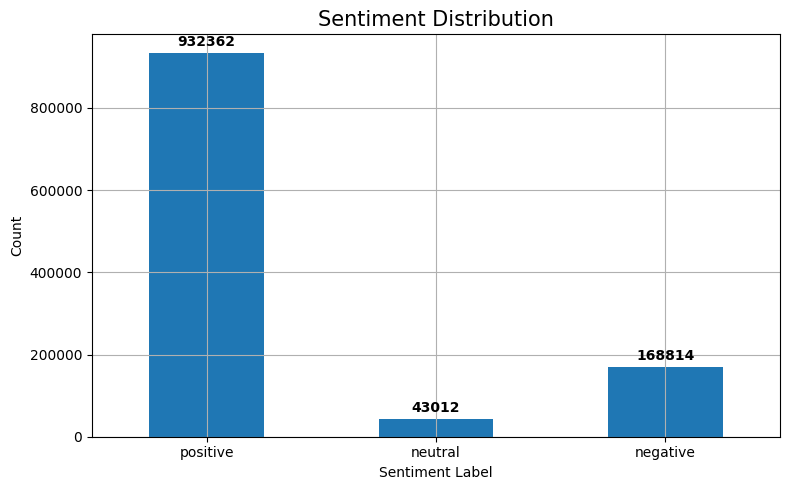

In [101]:
import matplotlib.pyplot as plt

# We created the bar plot and captured the Axes object
ax = sentiment_counts.plot(kind='bar', x='sentiment_label', y='count', figsize=(8, 5), legend=False)


for i, value in enumerate(sentiment_counts['count']):
    ax.text(i, value + 10000, str(value), ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation='horizontal')
plt.title('Sentiment Distribution', fontsize=15)
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.grid()
plt.tight_layout()
plt.show()

This bar chart shows how many reviews fall into each sentiment category: positive, neutral, and negative. Most reviews are positive (918,518), while negative reviews are fewer (166,905), and neutral ones are the least (42,359).

This imbalance suggests that any machine learning model might focus too much on predicting “positive” and ignore the other two. This can lead to unfair or inaccurate results, especially for neutral or negative reviews.

To mitigate this, we will balance the dataset so the model can learn from all categories more equally, aiming to achieve more accurate predictions.


## Most number of Positive Reviews on the Books

In [102]:
top_books = df.filter(df.sentiment_label == 'positive') \
              .groupBy("title") \
              .count() \
              .orderBy("count", ascending=False) \
              .limit(10)

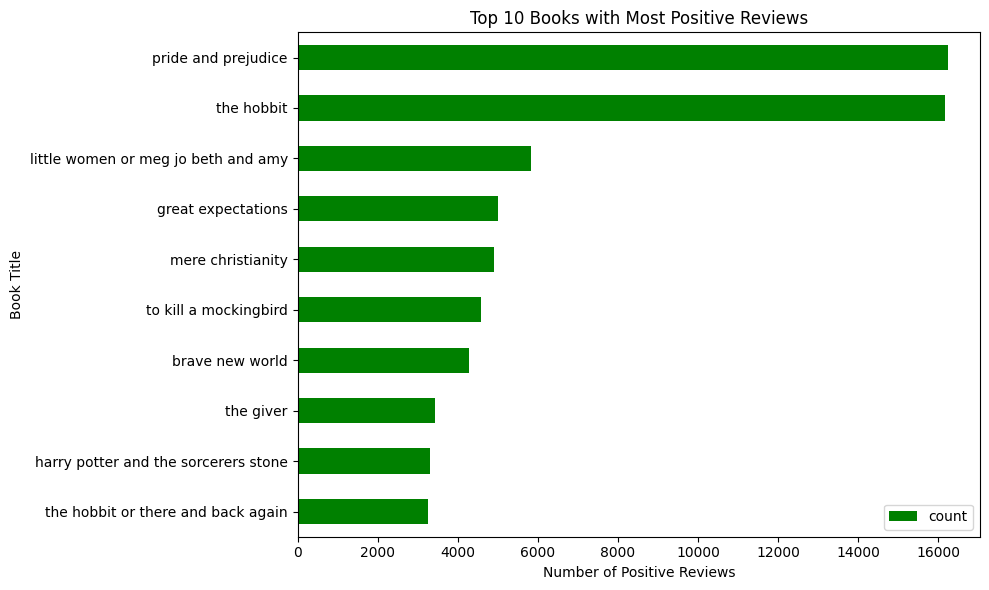

In [103]:
top_books_pd = top_books.toPandas()

top_books_pd.plot(kind='barh', x='title', y='count', figsize=(10, 6), color='green')
plt.gca().invert_yaxis()
plt.xlabel("Number of Positive Reviews")
plt.ylabel("Book Title")
plt.title("Top 10 Books with Most Positive Reviews")
plt.tight_layout()
plt.show()


## Most negative reviews per book

In [104]:
# Negative reviews
top_neg_books = df.filter(df.sentiment_label == 'negative') \
                  .groupBy("title") \
                  .count() \
                  .orderBy("count", ascending=False) \
                  .limit(10)

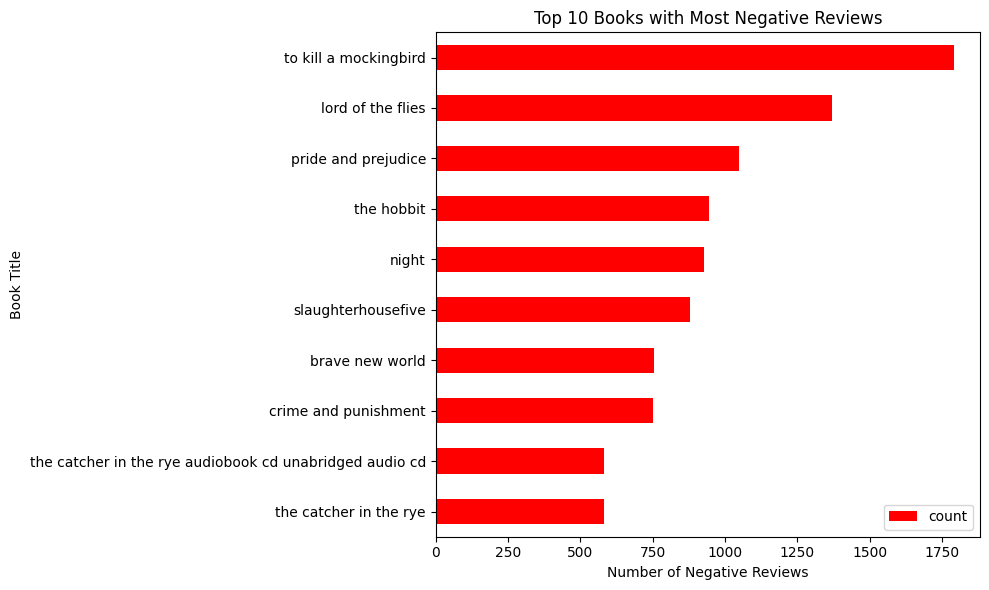

In [105]:
top_neg_books_pd = top_neg_books.toPandas()

import matplotlib.pyplot as plt


# Negative Reviews Plot
top_neg_books_pd.plot(kind='barh', x='title', y='count', color='red', figsize=(10, 6))
plt.title('Top 10 Books with Most Negative Reviews')
plt.xlabel('Number of Negative Reviews')
plt.ylabel('Book Title')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Neutral Reviews Per Book

In [106]:
top_neutral_books = df.filter(df.sentiment_label == 'neutral') \
                      .groupBy("title") \
                      .count() \
                      .orderBy("count", ascending=False) \
                      .limit(10)

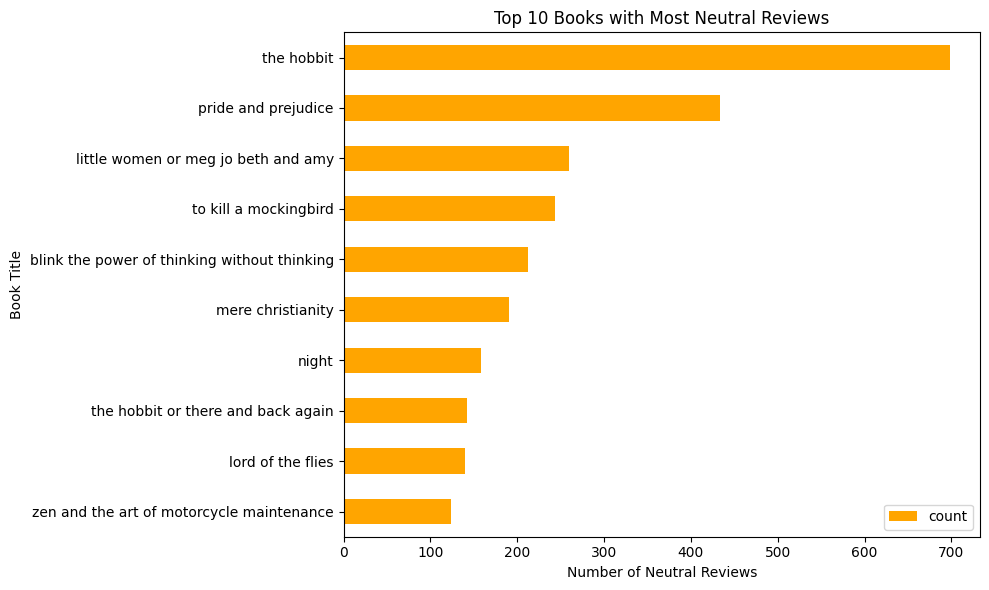

In [107]:
top_neutral_books_pd = top_neutral_books.toPandas()

top_neutral_books_pd.plot(kind='barh', x='title', y='count', color='orange', figsize=(10, 6))
plt.title('Top 10 Books with Most Neutral Reviews')
plt.xlabel('Number of Neutral Reviews')
plt.ylabel('Book Title')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Most Reviewed Books by Sentiment:

Τhis analysis shows how popular books tend to attract both praise and criticism simply because they reach a wider audience.

## Word clouds

Each showing the most common words per sentiment class

In [108]:
positive_tokens = df.filter(df.sentiment_label == 'positive') \
    .select("review_text_lemmatized").limit(10000).rdd.flatMap(lambda row: row[0]).collect()

negative_tokens = df.filter(df.sentiment_label == 'negative') \
    .select("review_text_lemmatized").limit(10000).rdd.flatMap(lambda row: row[0]).collect()

neutral_tokens = df.filter(df.sentiment_label == 'neutral') \
    .select("review_text_lemmatized").limit(10000).rdd.flatMap(lambda row: row[0]).collect()


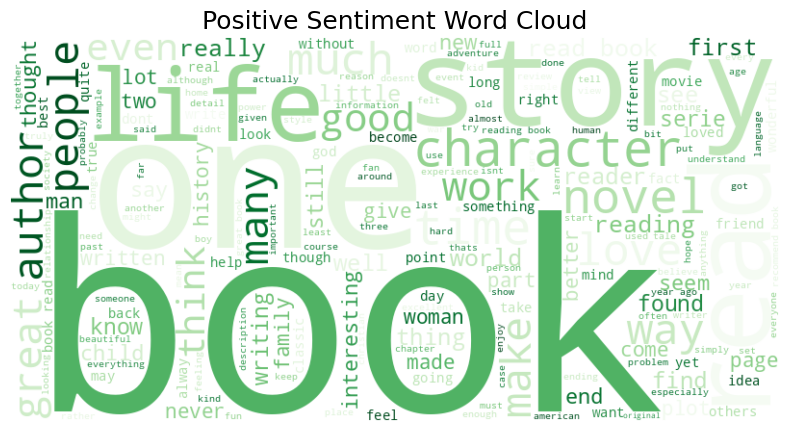

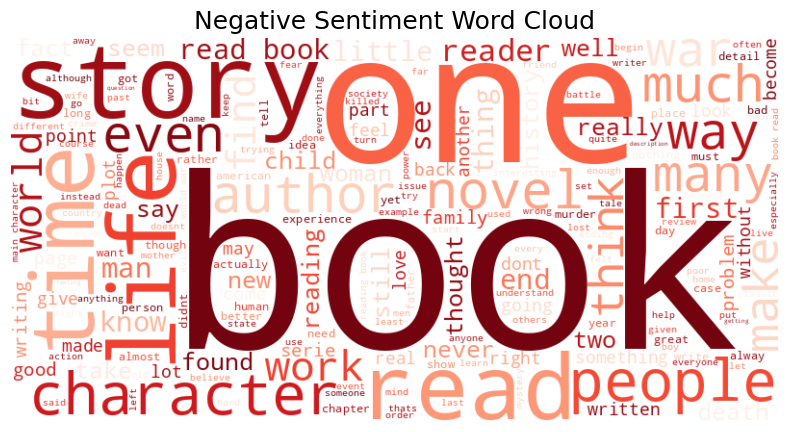

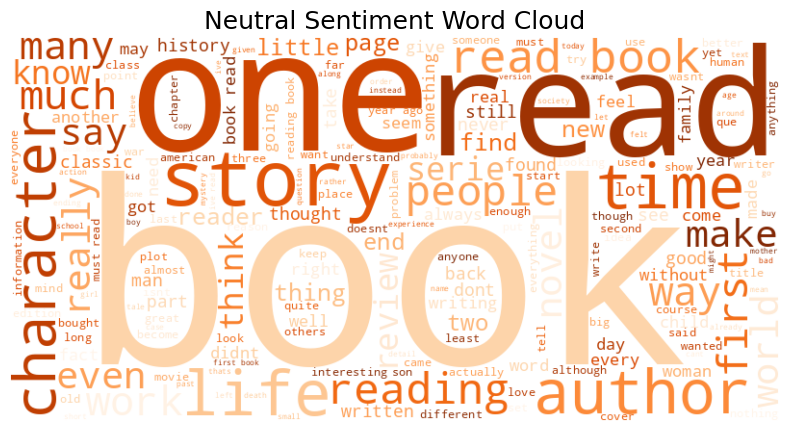

In [109]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def plot_wordcloud(tokens, title, color='black'):
    text = ' '.join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18)
    plt.show()


plot_wordcloud(positive_tokens, 'Positive Sentiment Word Cloud', color='Greens')
plot_wordcloud(negative_tokens, 'Negative Sentiment Word Cloud', color='Reds')
plot_wordcloud(neutral_tokens, 'Neutral Sentiment Word Cloud', color='Oranges')


## TF-IDF Top Words per Sentiment

Identify the most important words in positive vs negative reviews using TF-IDF (Term Frequency–Inverse Document Frequency).

In [110]:
df_filtered = df.filter(df.sentiment_label.isin("positive", "negative"))


In [111]:
df_pd = df_filtered.select("sentiment_label", "review_text_lemmatized").toPandas()
df_pd["text"] = df_pd["review_text_lemmatized"].apply(lambda tokens: ' '.join(tokens))


In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
import pandas as pd

# Separated texts
texts_pos = df_pd[df_pd["sentiment_label"] == "positive"]["text"]
texts_neg = df_pd[df_pd["sentiment_label"] == "negative"]["text"]

# Vectorizer
vectorizer = TfidfVectorizer(max_features=20)

# Positive
tfidf_pos = vectorizer.fit_transform(texts_pos)
top_pos = pd.DataFrame(tfidf_pos.toarray(), columns=vectorizer.get_feature_names_out()).mean().sort_values(ascending=False)

# Negative
tfidf_neg = vectorizer.fit_transform(texts_neg)
top_neg = pd.DataFrame(tfidf_neg.toarray(), columns=vectorizer.get_feature_names_out()).mean().sort_values(ascending=False)


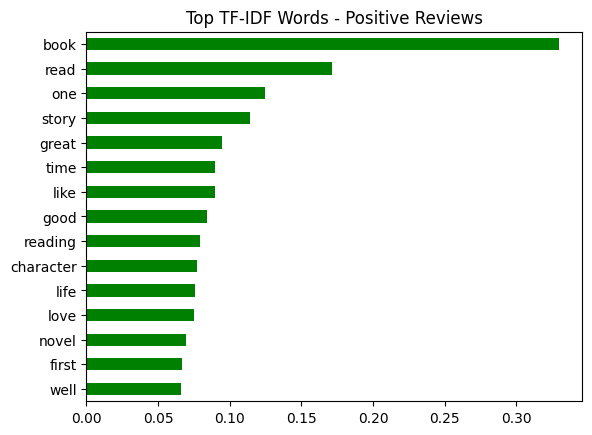

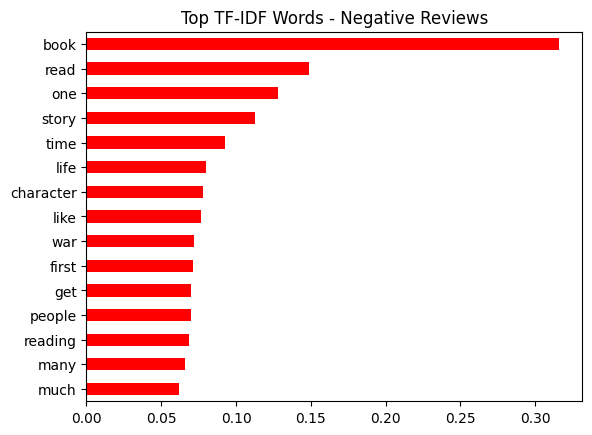

In [113]:
top_pos.head(15).plot(kind='barh', color='green', title='Top TF-IDF Words - Positive Reviews')
plt.gca().invert_yaxis()
plt.show()

top_neg.head(15).plot(kind='barh', color='red', title='Top TF-IDF Words - Negative Reviews')
plt.gca().invert_yaxis()
plt.show()


These charts highlight which words are most unique and meaningful in positive and negative reviews.

In both charts, we see that common terms like "book", "read", "one", and "story" appear often, which is reasonable because there are book reviews.

However, the positive reviews have more emotionally positive or enthusiastic words such as "great", "good", "love", "life", and "novel", suggesting that readers are expressing enjoyment and connection with the content. Wheresa the negative reviews include slightly more critical or neutral words like "war", "get", "many", and "much", which may relate to less satisfying experiences.

Overall, the TF-IDF analysis confirms that while core vocabulary is shared across both categories, certain words are more weighted in one sentiment category, giving us useful insight into how readers express positive or negative feelings.



##  Bigram Frequency Plots per Sentiment

Show most frequent 2-word phrases (bigrams) in reviews by sentiment.

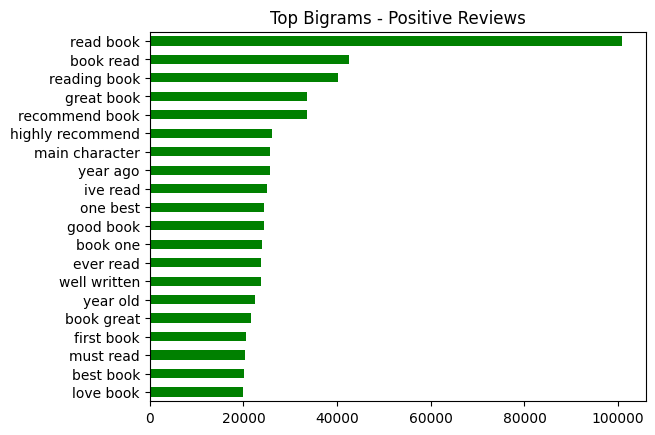

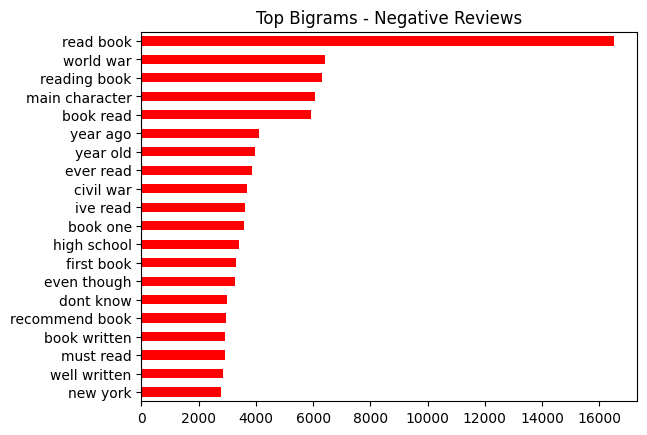

In [114]:
from sklearn.feature_extraction.text import CountVectorizer

bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=20)

# Positive
bigrams_pos = bigram_vectorizer.fit_transform(texts_pos)
bi_pos = pd.DataFrame(bigrams_pos.toarray(), columns=bigram_vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

# Negative
bigrams_neg = bigram_vectorizer.fit_transform(texts_neg)
bi_neg = pd.DataFrame(bigrams_neg.toarray(), columns=bigram_vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)


bi_pos.plot(kind='barh', color='green', title='Top Bigrams - Positive Reviews')
plt.gca().invert_yaxis()
plt.show()

bi_neg.plot(kind='barh', color='red', title='Top Bigrams - Negative Reviews')
plt.gca().invert_yaxis()
plt.show()


Bigram Analysis

In positive reviews, bigrams like "read book", "great book", and "highly recommend" appear frequently, suggesting that happy readers often talk about reading experiences and use strong positive expressions to recommend books.

In negative reviews, we still see "read book" and "main character", but also bigrams like "world war", "civil war", and "dont know". These may reflect reviews of books with heavy topics or cases where the reviewer was confused or dissatisfied.

##  Trigrams for Positive & Negative Sentiments

In [115]:
from pyspark.ml.feature import NGram

# We added a 'trigrams' column to the DataFrame
trigrammer = NGram(n=3, inputCol="review_text_lemmatized", outputCol="trigrams")
df_trigrams = trigrammer.transform(df)


In [116]:
positive_trigrams = df_trigrams.filter(df_trigrams.sentiment_label == "positive")
negative_trigrams = df_trigrams.filter(df_trigrams.sentiment_label == "negative")


In [117]:
from pyspark.sql.functions import explode, col

# Positive trigrams
positive_trigram_counts = (
    positive_trigrams.select(explode(col("trigrams")).alias("trigram"))
    .groupBy("trigram")
    .count()
    .orderBy("count", ascending=False)
    .limit(20)
    .toPandas()
)

# Negative trigrams
negative_trigram_counts = (
    negative_trigrams.select(explode(col("trigrams")).alias("trigram"))
    .groupBy("trigram")
    .count()
    .orderBy("count", ascending=False)
    .limit(20)
    .toPandas()
)


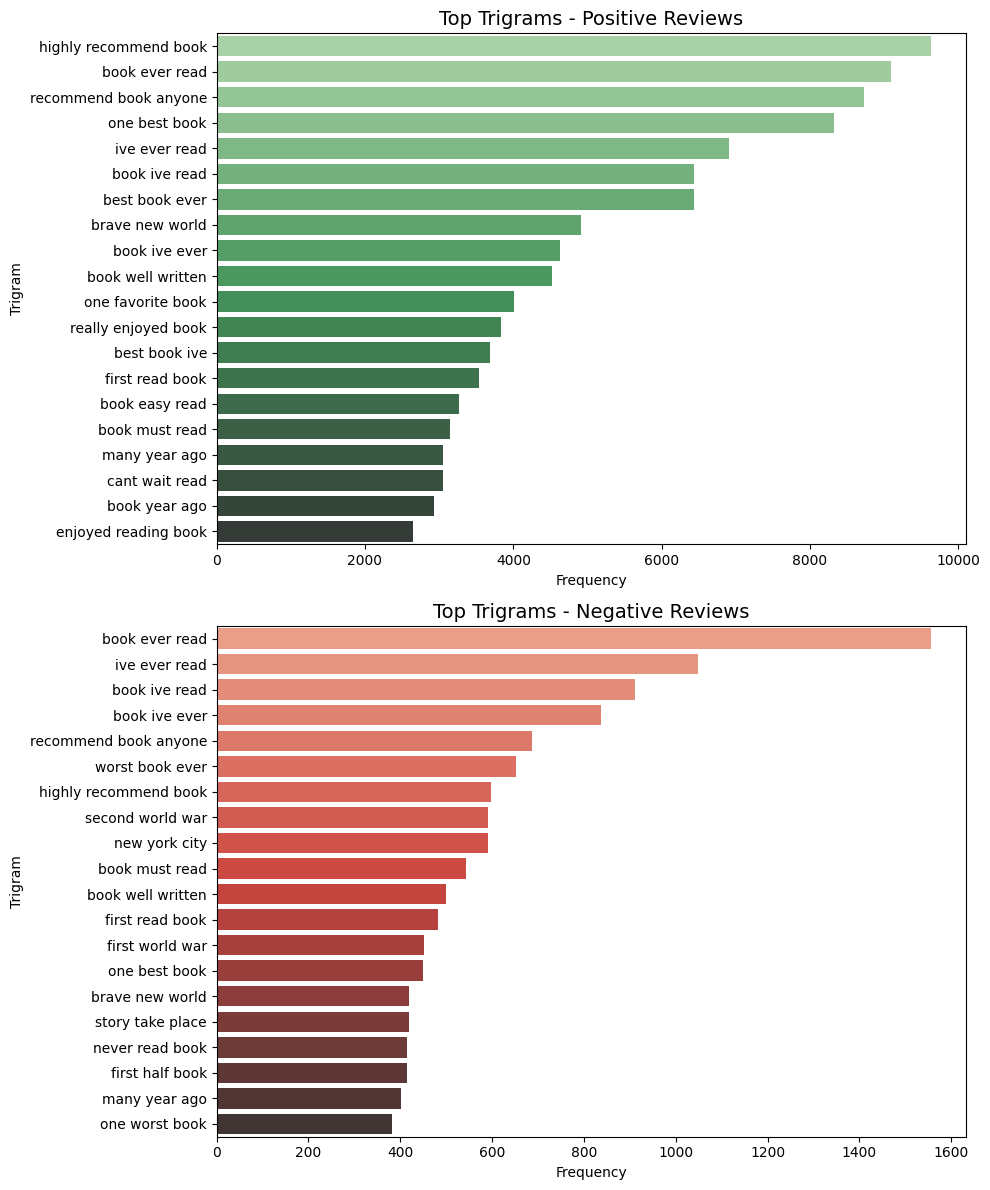

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up two vertical subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot positive trigrams
sns.barplot(ax=axes[0], data=positive_trigram_counts, y="trigram", x="count", palette="Greens_d")
axes[0].set_title("Top Trigrams - Positive Reviews", fontsize=14)
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Trigram")

# Plot negative trigrams
sns.barplot(ax=axes[1], data=negative_trigram_counts, y="trigram", x="count", palette="Reds_d")
axes[1].set_title("Top Trigrams - Negative Reviews", fontsize=14)
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Trigram")

plt.tight_layout()
plt.show()


In the positive reviews chart, trigrams like "highly recommend book", "book ever read", and "best book ever" are common suggesting that the readers where satisfied and enthusiastic with the book.

In the negative reviews chat, trigrams like  "worst book ever", "never read book", and "dont know" are common, suggesting that readers were dissapointed,confused or frustrated.

Overall, these charts help us to understand more deeply how readers describe their reading experiences using full phrases rather that just looking at single words.


## Helpfulness vs Sentiment

See whether helpful reviews are more likely to be positive or negative

In [119]:
helpful_sent = df.groupBy("helpfulness_category", "sentiment_label").count()
helpful_sent_pd = helpful_sent.toPandas().pivot(index="helpfulness_category", columns="sentiment_label", values="count").fillna(0)

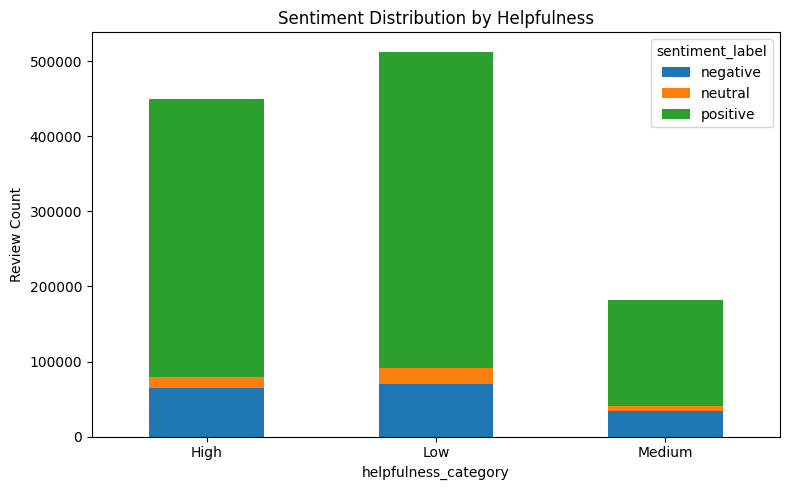

In [120]:
helpful_sent_pd.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("Sentiment Distribution by Helpfulness")
plt.ylabel("Review Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

This chart shows how review sentiment is distributed across three helpfulness categories: High, Medium, and Low.

From the chart we can see that
We can see that positive reviews appear in all categories, especially in the low and high helpfulness groups. Also the low helpfulness reviews are the most common overall.

This might suggest that readers tend to write many positive reviews even if others don’t find them very helpful. On the other hand, negative reviews are more common in the high helpfulness category,suggesting that people find negative reviews more useful or informative.

Overall, this chart shows a connection between review helpfulness and sentiment, giving us insight into how readers write and evaluate reviews.



## Dataframe of Reviews vs Sentiments

In [121]:
# We selected only the necessary columns
reviews_df = df.select("User_id","review_text_lemmatized", "sentiment_label")

reviews_df.limit(10000).toPandas()

,User_id,review_text_lemmatized,sentiment_label
0,A31WE0G828ZWY5,"[prepared, really, dislike, book, reason, take...",positive
1,A2VWX4T0DGWVCZ,"[lowkey, alternate, history, flint, previously...",positive
2,A2T47C5XF9FQI7,"[latest, book, rus, kick, brings, together, li...",positive
3,APM2YU1RVZ5Y7,"[solid, well, written, exceptional, look, nels...",positive
4,A1M5JC3NQ6CPN2,"[love, lkh, loved, abvh, sereies, loved, kiss,...",positive
...,...,...,...
9995,A3TPR8J28Q46OG,"[read, book, many, year, ago, right, came, out...",positive
9996,A1GSXYUQMMZ84N,"[worst, kind, reviewer, come, play, half, quot...",positive
9997,A2E0RIJFGH2AWH,"[thinking, actor, director, building, characte...",positive
9998,A33WJSZU9OYXF5,"[book, belongs, book, shelf, anyone, manages, ...",positive


# Model Training on Balanced Data

In [122]:
# We splited the balanced dataset into training and testing sets
# We performed an 80/20 split to train and evaluate the model
train_data, test_data = reviews_df.randomSplit([0.8, 0.2], seed=42)



In [123]:
from pyspark.ml.feature import CountVectorizer, IDF

# We defined the CountVectorizer and IDF stages
# These convert lemmatized text into numerical feature vectors
cv = CountVectorizer(inputCol="review_text_lemmatized", outputCol="raw_features", vocabSize=20000)
idf = IDF(inputCol="raw_features", outputCol="features")


In [124]:
from pyspark.ml.feature import StringIndexer

# Encode the Target Label (sentiment_label)
indexer = StringIndexer(inputCol="sentiment_label", outputCol="label")


# Logistic Regression Classifier on Imbalanced Model

In [125]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)


In [126]:
# We created and fit the pipeline
# The pipeline includes text vectorization (TF-IDF) and the logistic regression classifier
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[indexer, cv, idf, lr])

In [127]:
# We fited the Pipeline on the imbalanced training data
model_imbal = pipeline.fit(train_data)
indexer_model = model_imbal.stages[0]


In [128]:
predictions_imbal = model_imbal.transform(test_data)

In [129]:
from pyspark.sql.functions import col
from pyspark.ml.feature import IndexToString
import pandas as pd
from IPython.display import display

# Model prediction column is numeric (e.g., 0, 1, 2), but we want readable class names (e.g., "positive").
# This step maps the prediction numbers back to string labels (predicted_label) using the original indexer_model
label_reverse = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=indexer_model.labels)
predictions_named = label_reverse.transform(predictions_imbal)


In [130]:
# We prepared labels and metrics storage
# We got the list of all class labels used during training (e.g., ['negative', 'neutral', 'positive'])
# We created an empty list to store metrics for each class
labels = indexer_model.labels
metrics = []


In [131]:
# totals for averaging
# Macro averages: average across classes (equal weight)
# Weighted averages: average, weighted by the number of samples in each class
total_precision = 0
total_recall = 0
total_f1 = 0
total_support = 0

weighted_precision_sum = 0
weighted_recall_sum = 0
weighted_f1_sum = 0

In [132]:
# We calculated per-class metrics
# For each class:

# TP: correctly predicted as that class
# FP: wrongly predicted as that class
# FN: actually that class but predicted something else
# Support: total number of samples that truly belong to this class
# Then compute:

# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)
# F1-Score = harmonic mean of precision & recall
# Also,we added them to total counts to used later for averaging

for label in labels:
    tp = predictions_named.filter((col("sentiment_label") == label) & (col("predicted_label") == label)).count()
    fp = predictions_named.filter((col("sentiment_label") != label) & (col("predicted_label") == label)).count()
    fn = predictions_named.filter((col("sentiment_label") == label) & (col("predicted_label") != label)).count()
    support = predictions_named.filter(col("sentiment_label") == label).count()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    total_precision += precision
    total_recall += recall
    total_f1 += f1
    total_support += support

    weighted_precision_sum += precision * support
    weighted_recall_sum += recall * support
    weighted_f1_sum += f1 * support

    metrics.append((label, round(precision, 4), round(recall, 4), round(f1, 4), support))


In [133]:
# macro and weighted averages
# Macro average: simple average of metrics (good for evaluating performance equally across all classes)
# Weighted average: each class contributes proportionally to its size (more realistic when data is imbalanced)

num_labels = len(labels)
macro_precision = total_precision / num_labels
macro_recall = total_recall / num_labels
macro_f1 = total_f1 / num_labels

weighted_precision = weighted_precision_sum / total_support
weighted_recall = weighted_recall_sum / total_support
weighted_f1 = weighted_f1_sum / total_support



In [134]:
# overall accuracy
correct = predictions_named.filter(col("sentiment_label") == col("predicted_label")).count()
accuracy = correct / total_support

In [135]:
metrics.append(("macro avg", round(macro_precision, 4), round(macro_recall, 4), round(macro_f1, 4), total_support))
metrics.append(("weighted avg", round(weighted_precision, 4), round(weighted_recall, 4), round(weighted_f1, 4), total_support))
metrics.append(("accuracy", "", "", round(accuracy, 4), total_support))

print(f"Logistic Regression on Imbalanced Data")
metrics_df = pd.DataFrame(metrics, columns=["Class", "Precision", "Recall", "F1-Score", "Support"])
display(metrics_df)

Logistic Regression on Imbalanced Data


,Class,Precision,Recall,F1-Score,Support
0,positive,0.9462,0.9762,0.9610,186264
1,negative,0.8451,0.8007,0.8223,33822
2,neutral,0.7104,0.3753,0.4911,8777
3,macro avg,0.8339,0.7174,0.7581,228863
4,weighted avg,0.9222,0.9272,0.9224,228863
5,accuracy,,,0.9272,228863


### Per-Class Metrics Interpretation

#### Positive

Precision (0.9459): Out of all predictions labeled as positive, 94.59% were actually correct.
Recall (0.9758): Out of all true positive samples, 97.58% were correctly identified.
F1-Score (0.9606): Very high, indicating excellent performance for the positive class.

#### Negative

Precision (0.8427): 84.27% of predicted negatives were correct.
Recall (0.8021): The model correctly found 80.21% of true negatives.
F1-Score (0.8219): Strong performance overall for the negative class.

#### Neutral

Precision (0.6883): 68.83% of predicted neutral values were accurate.
Recall (0.349): Very low — the model only retrieved 34.90% of true neutral cases.
F1-Score (0.4631): Indicates that the model struggles with the neutral class.

#### Macro Average

This is the unweighted average across all classes  treats all classes equally, regardless of size.
Macro Precision: 0.8256, Macro Recall: 0.709, Macro F1-Score: 0.7486
Good for understanding class balance, especially in imbalanced datasets.

#### Weighted Average

This is a weighted mean where each class is weighted by its number of samples (support).
Reflects real-world performance more accurately in imbalanced datasets.
Weighted F1-Score: 0.9212  Excellent overall model performance.

The logistic regression model performs very well on the dominant positive and negative classes, achieving high precision, recall, and F1-scores. However, it struggles with the neutral class, as indicated by the low recall (34.87%) and F1-score (0.4629). While overall accuracy is high (92.64%), macro and weighted averages provide a more balanced view, confirming the model’s bias towards majority classes.

# Decision Tree Classifier on Imbalanced Model

In [136]:
from pyspark.ml.classification import DecisionTreeClassifier

In [137]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=5)  # You can tune maxDepth later

pipeline_dt = Pipeline(stages=[indexer, cv, idf, dt])
model_dt = pipeline_dt.fit(train_data)


In [138]:
indexer_model = model_dt.stages[0]


predictions_dt = model_dt.transform(test_data)

# We convert predicted labels back to string
label_reverse = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=indexer_model.labels)
predictions_named_dt = label_reverse.transform(predictions_dt)

In [139]:
from pyspark.sql.functions import col
import pandas as pd
from IPython.display import display

labels = indexer_model.labels
metrics = []

In [140]:
# Initialized accumulators
total_precision = 0
total_recall = 0
total_f1 = 0
total_support = 0

weighted_precision_sum = 0
weighted_recall_sum = 0
weighted_f1_sum = 0

In [141]:
# Per-class scores
for label in labels:
    tp = predictions_named_dt.filter((col("sentiment_label") == label) & (col("predicted_label") == label)).count()
    fp = predictions_named_dt.filter((col("sentiment_label") != label) & (col("predicted_label") == label)).count()
    fn = predictions_named_dt.filter((col("sentiment_label") == label) & (col("predicted_label") != label)).count()
    support = predictions_named_dt.filter(col("sentiment_label") == label).count()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    total_precision += precision
    total_recall += recall
    total_f1 += f1
    total_support += support

    weighted_precision_sum += precision * support
    weighted_recall_sum += recall * support
    weighted_f1_sum += f1 * support

    metrics.append((label, round(precision, 4), round(recall, 4), round(f1, 4), support))


In [142]:
# Macro and Weighted
num_labels = len(labels)
metrics.append(("macro avg", round(total_precision / num_labels, 4),
                round(total_recall / num_labels, 4),
                round(total_f1 / num_labels, 4), total_support))

metrics.append(("weighted avg", round(weighted_precision_sum / total_support, 4),
                round(weighted_recall_sum / total_support, 4),
                round(weighted_f1_sum / total_support, 4), total_support))


In [143]:
# Accuracy
correct = predictions_named_dt.filter(col("sentiment_label") == col("predicted_label")).count()
accuracy = correct / total_support
metrics.append(("accuracy", "", "", round(accuracy, 4), total_support))


In [144]:
print("Decision Tree on Imbalanced Data")
metrics_df_dt = pd.DataFrame(metrics, columns=["Class", "Precision", "Recall", "F1-Score", "Support"])
display(metrics_df_dt)


Decision Tree on Imbalanced Data


,Class,Precision,Recall,F1-Score,Support
0,positive,0.8285,0.9812,0.8984,186264
1,negative,0.5607,0.1372,0.2204,33822
2,neutral,0,0.0,0.0000,8777
3,macro avg,0.4631,0.3728,0.3729,228863
4,weighted avg,0.7572,0.8188,0.7638,228863
5,accuracy,,,0.8188,228863


### Per-Class Metrics Interpretation (Decision Tree Classifier on Imbalanced)

#### Positive

Precision (0.8283): Out of all the samples predicted as positive, 82.83% were actually correct.
Recall (0.9813): The model correctly identified 98.13% of all actual positive instances.
F1-Score (0.8984): Strong overall performance for the positive class, indicating high accuracy and completeness.

#### Negative

Precision (0.5668): Just 56.68% of predicted negatives were truly negative, indicating more false positives.
Recall (0.1386): Very low  the model only retrieved 13.86% of actual negative cases.
F1-Score (0.2228): Weak performance, meaning the model struggles significantly to detect the negative class.

#### Neutral

Precision (0.0000): None of the predictions for the neutral class were correct.
Recall (0.0000): The model completely failed to identify any actual neutral samples.
F1-Score (0.0000): Indicates total failure in recognizing or predicting the neutral class.


#### Macro Average

Macro Precision (0.4650), Macro Recall (0.3733), Macro F1-Score (0.3737):
These are the unweighted averages across the three classes. The low values reflect that the model performs well only for the positive class, while failing especially on the neutral class. This metric shows poor balance across the classes.

#### Weighted Average

Weighted Precision (0.7582), Recall (0.8188), F1-Score (0.7638):
These metrics take into account class imbalance. While the F1-score appears moderate (0.7638), it is heavily influenced by the large number of positive samples. It overstates the true model performance across minority classes.

#### Accuracy

Overall Accuracy: 81.88%  though this seems high, it is primarily driven by the model’s success in predicting the dominant positive class. It masks the poor performance on other classes, particularly neutral.


The Decision Tree model performs well on the positive class, with high recall and precision, but it struggles heavily with minority classes  especially the neutral class, which it fails to detect entirely. Although the accuracy is 81.88%, macro metrics reveal a large disparity between classes. This confirms that the model is biased towards the majority class, and additional strategies (like class weighting, resampling, or using ensemble methods) are needed to improve balance and detect underrepresented classes more effectively.

# Naivie Bayes Classifier on Imbalanced Model

In [145]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(labelCol="label", featuresCol="features")



In [146]:
pipeline_nb = Pipeline(stages=[indexer, cv, idf, nb])
model_nb = pipeline_nb.fit(train_data)

In [147]:
predictions_nb = model_nb.transform(test_data)

# We convert predicted labels back to string
from pyspark.ml.feature import IndexToString

label_reverse = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=indexer_model.labels)
predictions_named_nb = label_reverse.transform(predictions_nb)

In [148]:
from pyspark.sql.functions import col
import pandas as pd
from IPython.display import display

labels = indexer_model.labels
metrics = []

In [149]:
# Initialize accumulators
total_precision = 0
total_recall = 0
total_f1 = 0
total_support = 0

weighted_precision_sum = 0
weighted_recall_sum = 0
weighted_f1_sum = 0

In [150]:
# Per-class scores
for label in labels:
    tp = predictions_named_nb.filter((col("sentiment_label") == label) & (col("predicted_label") == label)).count()
    fp = predictions_named_nb.filter((col("sentiment_label") != label) & (col("predicted_label") == label)).count()
    fn = predictions_named_nb.filter((col("sentiment_label") == label) & (col("predicted_label") != label)).count()
    support = predictions_named_nb.filter(col("sentiment_label") == label).count()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    total_precision += precision
    total_recall += recall
    total_f1 += f1
    total_support += support

    weighted_precision_sum += precision * support
    weighted_recall_sum += recall * support
    weighted_f1_sum += f1 * support

    metrics.append((label, round(precision, 4), round(recall, 4), round(f1, 4), support))


In [151]:
# Macro and Weighted
num_labels = len(labels)
num_labels = len(labels)
macro_precision = total_precision / num_labels
macro_recall = total_recall / num_labels
macro_f1 = total_f1 / num_labels

weighted_precision = weighted_precision_sum / total_support
weighted_recall = weighted_recall_sum / total_support
weighted_f1 = weighted_f1_sum / total_support



In [152]:
# Accuracy
correct = predictions_named_nb.filter(col("sentiment_label") == col("predicted_label")).count()
accuracy = correct / total_support
metrics.append(("macro avg", round(macro_precision, 4), round(macro_recall, 4), round(macro_f1, 4), total_support))
metrics.append(("weighted avg", round(weighted_precision, 4), round(weighted_recall, 4), round(weighted_f1, 4), total_support))
metrics.append(("accuracy", "", "", round(accuracy, 4), total_support))


In [153]:
print("Naivie Bayes on Imbalanced Data")
metrics_df_nb = pd.DataFrame(metrics, columns=["Class", "Precision", "Recall", "F1-Score", "Support"])
display(metrics_df_nb)


Naivie Bayes on Imbalanced Data


,Class,Precision,Recall,F1-Score,Support
0,positive,0.9275,0.7924,0.8546,186264
1,negative,0.4771,0.6188,0.5388,33822
2,neutral,0.1498,0.4415,0.2237,8777
3,macro avg,0.5181,0.6175,0.5390,228863
4,weighted avg,0.8311,0.7533,0.7838,228863
5,accuracy,,,0.7533,228863


### Per-Class Metrics Interpretation (Naive Bayes Classifier)

#### Positive

Precision (0.9272): Out of all the predictions labeled as positive, 92.72% were actually correct  indicating very few false positives.
Recall (0.7897): The model identified 78.97% of all actual positive samples.
F1-Score (0.8529): A strong score, showing that the model is effective in recognizing and correctly predicting the positive class.

#### Negative

Precision (0.4762): Less than half of the predicted negatives were truly negative  high false positive rate.
Recall (0.6099): The model correctly retrieved 60.99% of all true negative cases.
F1-Score (0.5348): Indicates limited but slightly better detection of negative sentiment compared to Decision Tree.

#### Neutral

Precision (0.1427): Only 14.27% of samples predicted as neutral were actually neutral.
Recall (0.4411): The model retrieved just 44.11% of all neutral cases.
F1-Score (0.2157): Weak performance on neutral sentiment.

#### Macro Average

Macro Precision (0.5154), Macro Recall (0.6136), Macro F1-Score (0.5345)
These are the unweighted averages across the three classes.
They reflect that while the positive class is well classified, performance on neutral and negative is much worse.

#### Weighted Average

Precision (0.8304), Recall (0.7498), F1-Score (0.7815)
These values account for class support (sample size).
They appear stronger because the majority class (positive) dominates the dataset.

#### Accuracy

Accuracy: 74.98%
This means the model predicts the correct label 3 out of 4 times.

The Naive Bayes model performs very well on the positive class, with high precision and decent recall. It slightly outperforms Decision Tree on the neutral class but still struggles significantly to classify minority classes accurately.

While accuracy is 74.98%, it is inflated by correct predictions on the majority class. Macro metrics expose a clear imbalance in performance. This confirms the classifier’s bias toward the majority class.

## Balancing Data

### Downsampling the majority class (positive) while keeping all 3 sentiment classes: positive, negative, and neutral.

#### Reasons for Choosen Downsampling:

#### Avoids Synthetic Data Generation:
Unlike SMOTE (Synthetic Minority Oversampling Technique), downsampling uses only real data. This ensures that our model trains on actual user reviews, preserving the natural language structure and sentiment flow.

#### More Compatible with Text Data:
SMOTE is known to work best with continuous numerical features. In our case, where features are sparse and high dimensional (TF-IDF or CountVectorized vectors), synthetic interpolation would be unreliable and possibly misleading.

#### Simplicity and Speed:

Downsampling is fast, easy to implement, and integrates smoothly in distributed environments like Spark. Since we’re working with large-scale data, computational efficiency is critical.

#### Focus on Model Fairness:
Reducing the number of majority samples helps the classifier pay equal attention to all classes during training. This directly improves the macro-averaged metrics, which are more reflective of balanced performance.

In [154]:
# We separate each sentiment class
positive_df = df.filter(df.sentiment_label == 'positive')
negative_df = df.filter(df.sentiment_label == 'negative')
neutral_df  = df.filter(df.sentiment_label == 'neutral')


In [155]:
# the size of each class
pos_count = positive_df.count()
neg_count = negative_df.count()
neu_count = neutral_df.count()

# the minimum count to downsample to
min_count = min(pos_count, neg_count, neu_count)
print(f"Downsampling each class to: {min_count}")


Downsampling each class to: 43012


In [156]:
# Randomly downsample each class to min_count
positive_sample = positive_df.sample(withReplacement=False, fraction=min_count / pos_count, seed=42)
negative_sample = negative_df.sample(withReplacement=False, fraction=min_count / neg_count, seed=42)
neutral_sample  = neutral_df.sample(withReplacement=False, fraction=min_count / neu_count, seed=42)


In [157]:
# We combined all balanced samples into one DataFrame
balanced_df = positive_sample.union(negative_sample).union(neutral_sample)



In [158]:
# Grouped by sentiment label to confirm it's balanced
balanced_df.groupBy("sentiment_label").count().show()


+---------------+-----+
|sentiment_label|count|
+---------------+-----+
|       positive|42969|
|       negative|43375|
|        neutral|43012|
+---------------+-----+



In [159]:
balanced_df.limit(10000).toPandas()

,Title,description,publishedDate,ratingsCount,Id,User_id,profileName,review/summary,review/text,review/score,...,title_tokens,review_text_final,review_summary_final,description_final,title_final,review_text_lemmatized,review_text_len,category,compound,sentiment_label
0,a technique for producing ideas,a mcgrawhill advertising classic a technique f...,2003-01-21,6,B0007FQPBQ,A22BVT6LZVE13W,Dean Cowan,very limited in scope,a short book like this deserves a short review...,3.0,...,"[a, technique, for, producing, ideas]","[short, book, like, deserves, short, review, b...","[limited, scope]","[mcgrawhill, advertising, classic, technique, ...","[technique, producing, ideas]","[short, book, like, deserves, short, review, b...",338,Business & Economics,0.7650,positive
1,criminal minded,lamin michaels learned at his mothers knee the...,2005-06-01,5,B000GTDZBQ,A3FWVV13DJELLV,Ms. Read,another great one for tracy,i am a huge tracy brown fan and loved all of h...,4.0,...,"[criminal, minded]","[huge, tracy, brown, fan, loved, books, far, o...","[another, great, one, tracy]","[lamin, michaels, learned, mothers, knee, impo...","[criminal, minded]","[huge, tracy, brown, fan, loved, book, far, on...",182,Fiction,0.9633,positive
2,detroit then and now then now,founded in 1701 by antoine de le mothe cadilla...,2016-04-01,2,1571456899,A1VJC6SUYRRETB,Laura Gabriel,great perspective,ive enjoyed several history books about detroi...,5.0,...,"[detroit, then, and, now, then, , now]","[ive, enjoyed, several, history, books, detroi...","[great, perspective]","[founded, 1701, antoine, de, le, mothe, cadill...","[detroit, ]","[ive, enjoyed, several, history, book, detroit...",460,Photography,0.7845,positive
3,echoes,fastpaced and thrilling echoes is a heartpound...,2018-08-07,1,B000GQOQ4E,A72DN84Y5ZCWF,carol,echoes,i love that you can get lost in a maeve binchy...,5.0,...,[echoes],"[love, get, lost, maeve, binchy, story, shes, ...",[echoes],"[fastpaced, thrilling, echoes, heartpounding, ...",[echoes],"[love, get, lost, maeve, binchy, story, shes, ...",110,Young Adult Fiction,0.7906,positive
4,feet first a memoir,this is a story of a first generation son of i...,2003,1,1413405517,A3AAZOEAHV596W,Susan Watkins,a wonderful story,feet first is a wonderful story of every day l...,5.0,...,"[feet, first, a, memoir]","[feet, first, wonderful, story, every, day, li...","[wonderful, story]","[story, first, generation, son, immigrant, par...","[feet, first, memoir]","[foot, first, wonderful, story, every, day, li...",852,Biography & Autobiography,0.9484,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,the invasion of europe by the barbarians,the present series of lectures is designed to ...,2017-12-20,1,B000PS7DDE,AEFL7I22BB41J,Luciano Lupini,the barbarization of the roman empire a refres...,a clear introduction to the period of the barb...,5.0,...,"[the, invasion, of, europe, by, the, barbarians]","[clear, introduction, period, barbarian, invas...","[barbarization, roman, empire, refreshing, res...","[present, series, lectures, designed, give, br...","[invasion, europe, barbarians]","[clear, introduction, period, barbarian, invas...",1022,History,0.8750,positive
9996,where are they buried how did they die fitting...,the bestselling guide to the lives deaths and ...,2019-03-26,2,1579122876,AKMEY1BSHSDG7,J. Arena,interesting information well presented,my first impression of this book was to ask my...,5.0,...,"[where, are, they, buried, how, did, they, die...","[first, impression, book, ask, anyone, want, b...","[interesting, information, well, presented]","[bestselling, guide, lives, deaths, final, res...","[buried, die, fitting, ends, final, resting, p...","[first, impression, book, ask, anyone, want, b...",91,Travel,0.5423,positive
9997,a handful of stars,when lilys blind dog lucky slips his collar an...,2017-05-09,6,0441316158,A1ZC9NCRED15J7,"""MPMP """"mpmp1949""""""",dense pedestrian and boring,a rabid dana stabe

In [160]:
# Original counts
original_counts = df.groupBy("sentiment_label").count().toPandas()

# Balanced counts
balanced_counts = balanced_df.groupBy("sentiment_label").count().toPandas()


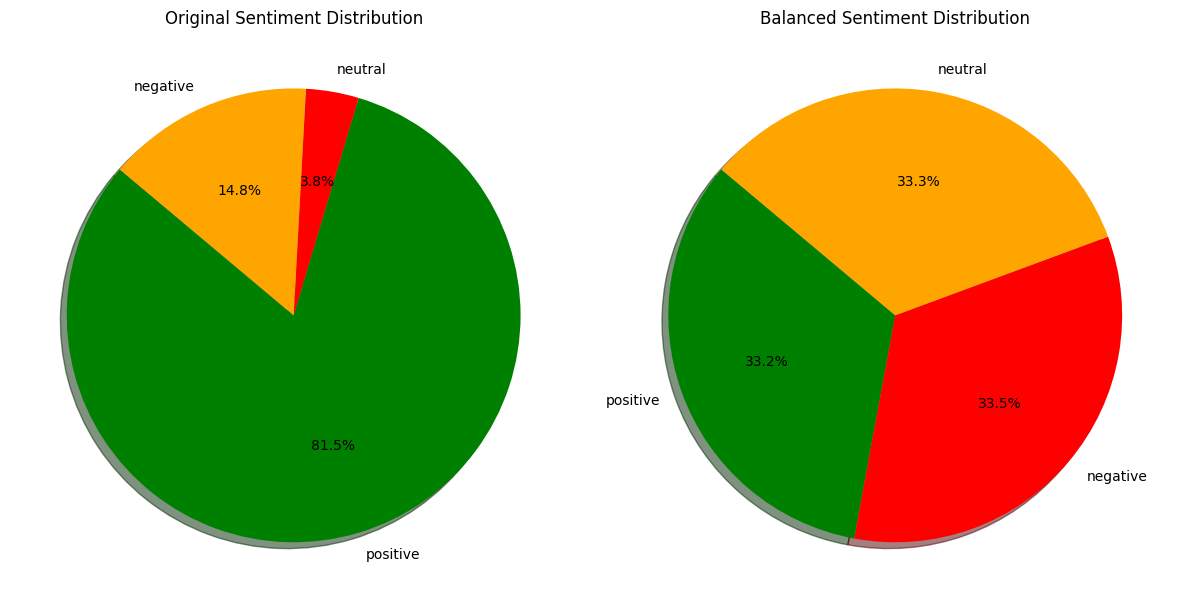

In [161]:
import matplotlib.pyplot as plt

# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


colors = ['green', 'red', 'orange']

# Unbalanced
axes[0].pie(
    original_counts["count"],
    labels=original_counts["sentiment_label"],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    shadow=True
)
axes[0].set_title("Original Sentiment Distribution")

# Balanced
axes[1].pie(
    balanced_counts["count"],
    labels=balanced_counts["sentiment_label"],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    shadow=True
)
axes[1].set_title("Balanced Sentiment Distribution")


plt.tight_layout()
plt.show()


In [162]:
# We selected only the necessary columns from the balanced data
reviews_df_bal = balanced_df.select("User_id","review_text_lemmatized", "sentiment_label")

reviews_df_bal.limit(1000).toPandas()

,User_id,review_text_lemmatized,sentiment_label
0,A22BVT6LZVE13W,"[short, book, like, deserves, short, review, b...",positive
1,A3FWVV13DJELLV,"[huge, tracy, brown, fan, loved, book, far, on...",positive
2,A1VJC6SUYRRETB,"[ive, enjoyed, several, history, book, detroit...",positive
3,A72DN84Y5ZCWF,"[love, get, lost, maeve, binchy, story, shes, ...",positive
4,A3AAZOEAHV596W,"[foot, first, wonderful, story, every, day, li...",positive
...,...,...,...
995,A3JMIWU9TRU45C,"[love, new, fae, world, walk, dark, enlightene...",positive
996,A12TV9XZKTMAS8,"[senior, college, allansons, killed, lived, mi...",positive
997,A2CAOVMHS84DEP,"[honest, expecting, book, first, picked, libra...",positive
998,AGVKKU8R5DI8H,"[admit, havent, finished, book, got, epilogue,...",positive


# Model Training on Balanced Data

In [163]:
# We splited the balanced dataset into training and testing sets
# We performed an 80/20 split to train and evaluate the model
train_bal, test_bal = reviews_df_bal.randomSplit([0.8, 0.2], seed=42)

In [164]:
# We Transformed labels using existing StringIndexer model (indexer_model)
# This ensures consistency with the label encoding used in the imbalanced model
train_bal = indexer_model.transform(train_bal)
test_bal = indexer_model.transform(test_bal)


In [165]:
# TF-IDF components for feature extraction
from pyspark.ml.feature import CountVectorizer, IDF

# We defined the CountVectorizer and IDF stages
# These convert lemmatized text into numerical feature vectors
cv = CountVectorizer(inputCol="review_text_lemmatized", outputCol="raw_features", vocabSize=20000)
idf = IDF(inputCol="raw_features", outputCol="features")

## Logistic Regression on Balanced Data

In [166]:
# Logistic Regression classifier
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)

In [167]:
# We created and fit the pipeline
# The pipeline includes text vectorization (TF-IDF) and the logistic regression classifier
from pyspark.ml import Pipeline
pipeline_bal = Pipeline(stages=[cv, idf, lr])
model_bal = pipeline_bal.fit(train_bal)


In [168]:
# predictions on the test set
predictions_bal = model_bal.transform(test_bal)

In [169]:
# We converted numeric prediction back to string labels for interpretability
from pyspark.ml.feature import IndexToString
label_reverse = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=indexer_model.labels)
predictions_named_bal = label_reverse.transform(predictions_bal)

In [170]:
# evaluation storage
from pyspark.sql.functions import col
import pandas as pd
from IPython.display import display

labels = indexer_model.labels
metrics = []

In [171]:
# accumulators for macro and weighted metrics
total_precision = 0
total_recall = 0
total_f1 = 0
total_support = 0

weighted_precision_sum = 0
weighted_recall_sum = 0
weighted_f1_sum = 0

In [172]:
# per-class metrics manually using Spark filters
for label in labels:
    tp = predictions_named_bal.filter((col("sentiment_label") == label) & (col("predicted_label") == label)).count()
    fp = predictions_named_bal.filter((col("sentiment_label") != label) & (col("predicted_label") == label)).count()
    fn = predictions_named_bal.filter((col("sentiment_label") == label) & (col("predicted_label") != label)).count()
    support = predictions_named_bal.filter(col("sentiment_label") == label).count()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    total_precision += precision
    total_recall += recall
    total_f1 += f1
    total_support += support

    weighted_precision_sum += precision * support
    weighted_recall_sum += recall * support
    weighted_f1_sum += f1 * support

    metrics.append((label, round(precision, 4), round(recall, 4), round(f1, 4), support))


In [173]:
# macro-averaged metrics
num_labels = len(labels)
macro_precision = total_precision / num_labels
macro_recall = total_recall / num_labels
macro_f1 = total_f1 / num_labels


In [174]:
# weighted-averaged metrics
weighted_precision = weighted_precision_sum / total_support
weighted_recall = weighted_recall_sum / total_support
weighted_f1 = weighted_f1_sum / total_support


In [175]:
# overall accuracy
correct = predictions_named_bal.filter(col("sentiment_label") == col("predicted_label")).count()
accuracy = correct / total_support

In [176]:
# summary metrics to the list
metrics.append(("macro avg", round(macro_precision, 4), round(macro_recall, 4), round(macro_f1, 4), total_support))
metrics.append(("weighted avg", round(weighted_precision, 4), round(weighted_recall, 4), round(weighted_f1, 4), total_support))
metrics.append(("accuracy", "", "", round(accuracy, 4), total_support))


In [177]:
metrics_df_regbl = pd.DataFrame(metrics, columns=["Class", "Precision", "Recall", "F1-Score", "Support"])
print("Logistic Regression on Balanced Data")
display(metrics_df_regbl)

Logistic Regression on Balanced Data


,Class,Precision,Recall,F1-Score,Support
0,positive,0.834,0.798,0.8156,8658
1,negative,0.7775,0.7344,0.7554,8675
2,neutral,0.7272,0.7989,0.7614,8668
3,macro avg,0.7796,0.7771,0.7774,26001
4,weighted avg,0.7796,0.7771,0.7774,26001
5,accuracy,,,0.7771,26001


### Per-Class Metrics Interpretation (Logistic Regression on Balanced Data)

#### Positive

Precision (0.8363): 83.63% of reviews predicted as positive were actually positive. Recall (0.8027): The model correctly identified 80.27% of all true positive reviews. F1-Score (0.8192): High, indicating that the model continues to perform well on positive reviews.

#### Negative

Precision (0.7702): 77.02% of the model’s negative predictions were correct. Recall (0.7325): the model correctly found 73.25% of true negavites. F1-Score (0.7509): Moderate performance in identifying negatives.

#### Neutral

Precision (0.7233): 72.33% of neutral predictions were correct. Recall (0.7877): It retrieved almost 79% of all true neutral reviews. F1-Score (0.7541): Moderate performance in identifying neutrals,

#### Macro Average
This is the unweighted average across all classes, treating each class equally regardless of its size. Macro precision 0.7766, Macro recall 0.7743, Macro F1-score 0.7747. This suggests that the model handles each class fairly well .


#### Weighted Averages
This is a weighted mean where each class is weighted by its number of samples (support). Weighted F1-score: 0.7747 suggests that the model generally performs quite well.





# Decision Tree Classifier on Imbalanced Model

In [178]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF, StringIndexer, IndexToString
from pyspark.sql.functions import col
import pandas as pd
from IPython.display import display



In [179]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")


In [180]:
pipeline_dt_bal = Pipeline(stages=[cv, idf, dt])

model_dt_bal = pipeline_dt_bal.fit(train_bal)

In [181]:
indexer_model = model_dt.stages[0]

predictions_dt_bal = model_dt_bal.transform(test_bal)

label_reverse = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=indexer_model.labels)
predictions_named_bal_dt = label_reverse.transform(predictions_dt_bal)

In [182]:
# evaluation storage
from pyspark.sql.functions import col
import pandas as pd
from IPython.display import display

labels = indexer_model.labels
metrics = []

In [183]:
# accumulators for macro and weighted metrics
total_precision = 0
total_recall = 0
total_f1 = 0
total_support = 0

weighted_precision_sum = 0
weighted_recall_sum = 0
weighted_f1_sum = 0

In [184]:
# per-class metrics manually using Spark filters
for label in labels:
    tp = predictions_named_bal_dt.filter((col("sentiment_label") == label) & (col("predicted_label") == label)).count()
    fp = predictions_named_bal_dt.filter((col("sentiment_label") != label) & (col("predicted_label") == label)).count()
    fn = predictions_named_bal_dt.filter((col("sentiment_label") == label) & (col("predicted_label") != label)).count()
    support = predictions_named_bal_dt.filter(col("sentiment_label") == label).count()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    total_precision += precision
    total_recall += recall
    total_f1 += f1
    total_support += support

    weighted_precision_sum += precision * support
    weighted_recall_sum += recall * support
    weighted_f1_sum += f1 * support

    metrics.append((label, round(precision, 4), round(recall, 4), round(f1, 4), support))


In [185]:
# macro-averaged metrics
num_labels = len(labels)
macro_precision = total_precision / num_labels
macro_recall = total_recall / num_labels
macro_f1 = total_f1 / num_labels


In [186]:
# weighted-averaged metrics
weighted_precision = weighted_precision_sum / total_support
weighted_recall = weighted_recall_sum / total_support
weighted_f1 = weighted_f1_sum / total_support


In [187]:
# overall accuracy
correct = predictions_named_bal.filter(col("sentiment_label") == col("predicted_label")).count()
accuracy = correct / total_support

In [188]:
# summary metrics to the list
metrics.append(("macro avg", round(macro_precision, 4), round(macro_recall, 4), round(macro_f1, 4), total_support))
metrics.append(("weighted avg", round(weighted_precision, 4), round(weighted_recall, 4), round(weighted_f1, 4), total_support))
metrics.append(("accuracy", "", "", round(accuracy, 4), total_support))


In [189]:
metrics_df_dtbl = pd.DataFrame(metrics, columns=["Class", "Precision", "Recall", "F1-Score", "Support"])
print("Decision Tree on Balanced Data")
display(metrics_df_dtbl)

Decision Tree on Balanced Data


,Class,Precision,Recall,F1-Score,Support
0,positive,0.6475,0.4212,0.5104,8658
1,negative,0.4866,0.4285,0.4557,8675
2,neutral,0.5225,0.7673,0.6216,8668
3,macro avg,0.5522,0.539,0.5293,26001
4,weighted avg,0.5521,0.539,0.5292,26001
5,accuracy,,,0.7771,26001


### Per-Class Metrics Interpretation (Decision Tree on Balanced Data)

#### Positive

Precision (0.6772): Out of all samples predicted as positive, 67.72% were actually correct.
Recall (0.3839): The model correctly identified only 38.39% of actual positive cases.
F1-Score (0.4900): Indicates weak performance for the positive class, especially in recall.

#### Negative

Precision (0.4708): Only 47.08% of predicted negatives were correct, showing a high number of false positives.
Recall (0.4432): The model identified 44.32% of true negative cases.
F1-Score (0.4566): Reflects generally poor ability to classify negative reviews.

#### Neutral

Precision (0.5217): Just over half of predicted neutral reviews were correct.
Recall (0.7775): The model successfully retrieved a high portion of actual neutral reviews.
F1-Score (0.6244): Shows moderate performance for the neutral class, doing better than the other two in terms of recall.

#### Macro Average

Macro Precision (0.5566), Macro Recall (0.5349), Macro F1-Score (0.5237): These are unweighted averages, treating each class equally. The moderate values suggest the model performs inconsistently across the classes, with the neutral class performing best and the others much worse.

#### Weighted Average

Weighted Precision (0.5565), Recall (0.5349), F1-Score (0.5237): These metrics account for class size. The moderate F1-score reflects the uneven class-wise performance, especially the poor results for positive and negative classes.

#### Accuracy

Overall Accuracy: 77.43%: While this number appears acceptable, it does not reflect the model’s weaker ability to accurately classify positive and negative reviews. It is mostly driven by the model’s decent recall for neutral cases.



# Naivie Bayes Classifier on Balanced Model

In [190]:
# Naivie Bayes Classifier
nb = NaiveBayes(labelCol="label", featuresCol="features")

In [191]:
pipeline_nb_bal = Pipeline(stages=[cv, idf, nb])

model_nb_bal = pipeline_nb_bal.fit(train_bal)

In [192]:
predictions_nb_bal = model_nb_bal.transform(test_bal)

label_reverse = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=indexer_model.labels)
predictions_named_bal_nb = label_reverse.transform(predictions_nb_bal)

In [193]:
# evaluation storage
from pyspark.sql.functions import col
import pandas as pd
from IPython.display import display

labels = indexer_model.labels
metrics = []

In [194]:
# accumulators for macro and weighted metrics
total_precision = 0
total_recall = 0
total_f1 = 0
total_support = 0

weighted_precision_sum = 0
weighted_recall_sum = 0
weighted_f1_sum = 0

In [195]:
# Per-class scores
for label in labels:
    tp = predictions_named_bal_nb.filter((col("sentiment_label") == label) & (col("predicted_label") == label)).count()
    fp = predictions_named_bal_nb.filter((col("sentiment_label") != label) & (col("predicted_label") == label)).count()
    fn = predictions_named_bal_nb.filter((col("sentiment_label") == label) & (col("predicted_label") != label)).count()
    support = predictions_named_bal_nb.filter(col("sentiment_label") == label).count()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    total_precision += precision
    total_recall += recall
    total_f1 += f1
    total_support += support

    weighted_precision_sum += precision * support
    weighted_recall_sum += recall * support
    weighted_f1_sum += f1 * support

    metrics.append((label, round(precision, 4), round(recall, 4), round(f1, 4), support))


In [196]:
# macro-averaged metrics
num_labels = len(labels)
macro_precision = total_precision / num_labels
macro_recall = total_recall / num_labels
macro_f1 = total_f1 / num_labels


In [197]:
# weighted-averaged metrics
weighted_precision = weighted_precision_sum / total_support
weighted_recall = weighted_recall_sum / total_support
weighted_f1 = weighted_f1_sum / total_support


In [198]:
# overall accuracy
correct = predictions_named_bal_nb.filter(col("sentiment_label") == col("predicted_label")).count()
accuracy = correct / total_support

In [199]:
metrics.append(("macro avg", round(macro_precision, 4), round(macro_recall, 4), round(macro_f1, 4), total_support))
metrics.append(("weighted avg", round(weighted_precision, 4), round(weighted_recall, 4), round(weighted_f1, 4), total_support))
metrics.append(("accuracy", "", "", round(accuracy, 4), total_support))


In [200]:
metrics_df_nbbl = pd.DataFrame(metrics, columns=["Class", "Precision", "Recall", "F1-Score", "Support"])
print("Naivie Bayes on Balanced Data")
display(metrics_df_nbbl)

Naivie Bayes on Balanced Data


,Class,Precision,Recall,F1-Score,Support
0,positive,0.6324,0.7277,0.6767,8658
1,negative,0.6715,0.622,0.6458,8675
2,neutral,0.6464,0.5968,0.6206,8668
3,macro avg,0.6501,0.6488,0.6477,26001
4,weighted avg,0.6501,0.6488,0.6477,26001
5,accuracy,,,0.6488,26001


### Per-Class Metrics Interpretation (Naive Bayes Classifier on Balanced Data)

#### Positive

Precision (0.6385): Out of all reviews predicted as positive, 63.85% were correct.
Recall (0.7344): The model correctly identified 73.44% of actual positive reviews.
F1-Score (0.6831): Indicates solid performance on the positive class, especially in terms of recall.

#### Negative

Precision (0.6636): The model was correct 66.36% of the time when predicting negative reviews.
Recall (0.6318): It retrieved 63.18% of true negative cases.
F1-Score (0.6473): Shows balanced performance on the negative class.

#### Neutral

Precision (0.6541): About 65.41% of predicted neutral reviews were accurate.
Recall (0.5874): The model retrieved 58.74% of actual neutral reviews.
F1-Score (0.6190): Slightly lower than the others, but still represents fair performance for the neutral class.

#### Macro Average

Macro Precision (0.6521), Macro Recall (0.6512), Macro F1-Score (0.6498): These values represent the unweighted mean across all classes. The scores are relatively balanced, indicating that the model performs fairly evenly across all sentiments.

#### Weighted Average

Weighted Precision (0.6521), Recall (0.6511), F1-Score (0.6498): These metrics consider the number of samples per class. Since the dataset is balanced, the weighted and macro averages are nearly identical, confirming consistent overall model performance.

#### Accuracy

Overall Accuracy: 65.11%: The model achieves a moderate level of accuracy across all classes. While not highly precise, it performs steadily without heavily favoring any specific sentiment.

# Conclusion- Text Analysis

### Logistic Regression: Imbalanced vs Balanced

On the imbalanced dataset, logistic regression shows excellent performance for the dominant class (positive), with a very high F1-score of 0.9606, precision of 0.9459, and recall of 0.9758. The model also performs well on the negative class (F1-score: 0.8219), but struggles with the neutral class, achieving a much lower F1-score of 0.4631 and recall of only 0.349. Despite an overall accuracy of 92.64%, this is mainly due to the large number of positive samples. The macro average F1-score of 0.7486 and weighted average F1-score of 0.9212 highlight this imbalance.

On the balanced dataset, performance becomes more stable across all three classes. The neutral class improves significantly, with an F1-score of 0.7541, and recall rising to 0.7877, showing the model is now better at recognizing minority classes. However, performance on the positive class slightly drops (F1-score: 0.8192), as the model no longer benefits from the class imbalance. Overall, the macro and weighted F1-scores are both 0.7747, and the accuracy drops to 77.43%, which is expected when the model is evaluated more fairly across all classes.

In conlusion the model performs best on the imbalanced dataset in terms of raw accuracy, but this is misleading because it focuses too heavily on the majority class. On the balanced dataset, performance is more fair and consistent across all classes, especially improving detection of neutral reviews. Balanced training is clearly more appropriate for tasks where every class matters equally, such as multi-class sentiment classification.

### Decision Tree: Balanced vs Imbalanced Data
On the imbalanced dataset, the decision tree shows strong performance for the positive class, achieving a high F1-score of 0.8984, precision of 0.8283, and recall of 0.9813. However, it performs poorly on the negative class (F1-score: 0.2228), with recall dropping to just 0.1386. The model completely fails to detect the neutral class, with both precision and recall at 0.0000. While the overall accuracy appears decent at 81.88%, this is mostly due to the overwhelming number of positive samples. The macro average F1-score is just 0.3737, and the weighted F1-score is 0.7638, both indicating heavy bias toward the dominant class.

On the balanced dataset, the model’s performance becomes slightly more even across classes. The neutral class sees substantial improvement, reaching an F1-score of 0.6244 and recall of 0.7775, which shows it is now being recognized by the model. Performance on the positive class drops sharply (F1-score: 0.4900), and the negative class also sees only moderate improvement (F1-score: 0.4566). Overall accuracy is 77.43%, with macro and weighted F1-scores both at 0.5237, reflecting a more realistic view of the model’s capabilities when class imbalance is removed.

In conclusion, on the imbalanced dataset, the decision tree is highly accurate but only for the dominant class, completely failing to detect neutral reviews. On the balanced dataset, the model becomes more inclusive, especially improving its recognition of neutral reviews, but performance overall drops due to its limited ability to generalize. This shows that while decision trees may look impressive on skewed data, they are less reliable for multi-class tasks unless class balance is ensured.

### Naive Bayes: Balanced vs Imbalanced Data
On the imbalanced dataset, Naive Bayes performs very well on the dominant positive class, achieving a high F1-score of 0.8529, with precision 0.9272 and recall 0.7897. However, it struggles significantly with the minority classes. For the negative class, the F1-score drops to 0.5348, and for the neutral class, the model performs poorly, with a very low F1-score of 0.2157 and recall of just 0.4411. The overall accuracy is 74.98%, but this is mainly driven by the overrepresentation of positive samples. The macro average F1-score of 0.5345 highlights poor balance in performance across all classes, while the weighted average F1-score of 0.7815 overstates the true general performance due to class imbalance.

On the balanced dataset, performance becomes more even across the three sentiment classes. The neutral class improves significantly, now reaching an F1-score of 0.6190 with recall 0.5874, while the positive and negative classes maintain reasonably balanced scores (F1-scores: 0.6831 and 0.6473, respectively). The macro and weighted F1-scores are both around 0.6498, and accuracy is 65.11%. Although overall accuracy dropped compared to the imbalanced case, the model now gives fairer attention to all classes.

In conclusion, on imbalanced data, Naive Bayes favors the majority class (positive), resulting in misleadingly high performance. Balancing the dataset leads to more consistent results across all sentiment categories, particularly improving performance on the neutral class. While the accuracy is lower with balanced data, the model's performance is more representative of its ability to generalize across all labels.

# Advanced Analysis
# Clustering

We aim to analyze book reviews using two main techniques:

1)Clustering (with KMeans) to group reviews by similarity

2)Topic Modeling (with LDA) to uncover hidden themes discussed across reviews

To do this, we combine relevant cleaned text fields, transform them into numeric features, then apply clustering and topic modeling.

#### Combining All Cleaned Text Features

#### Feature Vectorisation
1.TF-IDF Vectorization for KMeans Clustering

-Efficient on large datasets

-Useful for grouping similar reviews into clusters

-Works well with numerical vectors like TF-IDF

TF-IDF assigns more weight to rare but meaningful words, which helps clustering models better separate documents based on unique terms. It gives us a basic numeric version of the text. TF-IDF goes a step further. It not only counts words, but also checks how unique each word is across all reviews. Rare but important words get more value.

In [201]:
#Combine preprocessed token arrays into one array column
from pyspark.sql.functions import col, array, flatten
df = df.withColumn(
    "combined_tokens",
    flatten(array(
        col("review_text_final"),
        col("review_summary_final"),
        col("description_final"),
        col("title_final")
    ))
)

In [202]:
from pyspark.ml.feature import HashingTF, IDF
# TF-IDF setup using HashingTF + IDF
hashing_tf = HashingTF(inputCol= "combined_tokens", outputCol="raw_tf", numFeatures=10000)
tf_model = hashing_tf.transform(df)

idf = IDF(inputCol="raw_tf", outputCol="tfidf_vector")
idf_model = idf.fit(tf_model)
df_tfidf = idf_model.transform(tf_model)

#### Vector Assembler
We group some useful numeric features like review/score_int, review_helpfulness, and review_text_len into one single column. This is so we can use them easily later in our models. We have chosen to use review/score_int instead of review/score because treating scores as discrete categories (e.g 1-5) is usually more interpretable and stable for clustering

In [203]:
from pyspark.ml.feature import VectorAssembler

features = ["review/score_int", "review_helpfulness", "review_text_len", "ratingsCount"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_vector = assembler.transform(df)

#### Elbow Method (with TF-IDF) To Determine Optimal K
We use the elbow method by plotting WSSSE (within-cluster variance) vs number of clusters k. The "elbow" shows a good tradeoff between cluster quality and model complexity.

We determine the optimal number of clusters (k=6) using the Elbow Method on TF-IDF features. Since TF-IDF gives a better numeric representation for clustering, we apply the same k to LDA for consistency in comparing topic and cluster structure, even though LDA is run on CountVectorizer for better topic word interpretability.

#### KMeans Clustering (using TF-IDF) with optimal K
We set up the KMeans model to split our data into 10 groups (clusters) based on how similar the text content is.

#### Fit the Model
Here we train the model using the TF-IDF vectors. It learns patterns in the text and figures out how to group the reviews into clusters.

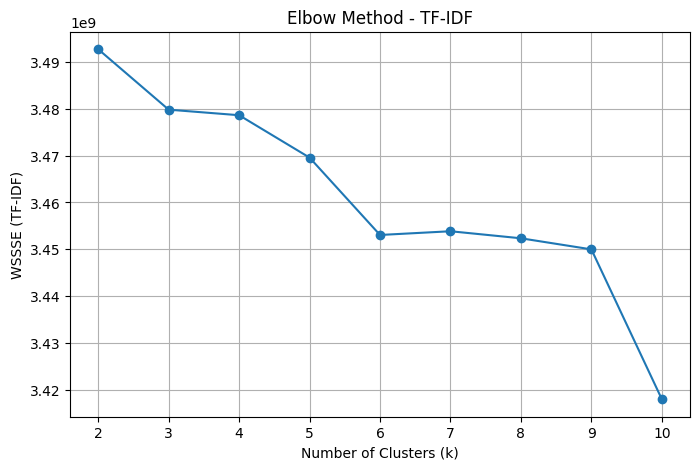

In [204]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

costs_tfidf = []
K = list(range(2, 11))


df_tfidf.cache()
df_tfidf.count() 


for k in K:
    kmeans = KMeans(featuresCol="tfidf_vector", k=k, seed=1)
    model = kmeans.fit(df_tfidf)
    cost = model.summary.trainingCost
    costs_tfidf.append(cost)

plt.figure(figsize=(8, 5))
plt.plot(K, costs_tfidf, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSSSE (TF-IDF)')
plt.title('Elbow Method - TF-IDF')
plt.grid(True)
plt.show()

In [ ]:
from pyspark.ml.clustering import KMeans

# Initialize KMeans with 10 clusters 
kmeans = KMeans(featuresCol="tfidf_vector", predictionCol="cluster", k=6, seed=1)

In [ ]:
model = kmeans.fit(df_tfidf)

#### 2. LDA Topic Modeling with CountVectorize
We apply LDA on raw word count vectors (from CountVectorizer) to uncover hidden themes in reviews. We use CountVectorizer to convert tokens into word count vectors. This is preferred for LDA because it:

Preserves word frequencies

Keeps term indices interpretable

Works better with discrete topic distributions

Count_vectorizer converts the words in combined_tokens into numbers by counting how often each word appears.

In [ ]:
from pyspark.ml.feature import CountVectorizer, IDF, HashingTF

# CountVectorizer setup
count_vectorizer = CountVectorizer(inputCol="combined_tokens", outputCol="count_vector",vocabSize=5000, minDF=10) 
df.cache()



#### Fit CountVectorizer on the sample & transform on the full data
Fit on small data, apply to full , we need to be cautious that rare tokens may be missed in the sample.

In [ ]:
cv_model = count_vectorizer.fit(df)
df_cv = cv_model.transform(df)

#### LDA (Latent Dirichlet Allocation)
Soft Clustering Based On Topic Distributions:

We use PySpark's LDA() on the CountVectorizer features to extract topics across the dataset. We want to uncover hidden themes. We use CountVectorizer for LDA because it retains raw word frequencies and enables clear mapping of topic indices to readable terms, unlike TF-IDF which suppresses common but informative words.

Note: We use the same optimal k from TF-IDF elbow method here to maintain consistency across KMeans and LDA. This enables better comparison of semantic clusters (from KMeans) and topic themes (from LDA) using the same group size.

In [ ]:
from pyspark.ml.clustering import LDA

# Initialize LDA with desired number of topics (you can tune k later)
lda = LDA(featuresCol="count_vector", k=6, maxIter=10, seed=42) # We use the same optimal k from TF-IDF elbow method here.


# Fit the LDA model
lda_model = lda.fit(df_cv)

# Transform to get topic distribution per document
df_topics = lda_model.transform(df_cv)

# Show a few rows of topic distribution per document
df_topics.select("topicDistribution").show(truncate=False)

#### Extracting top keywords per topic using CountVectorizer (from the fitted LDA model)

In [ ]:
# Describe topics with top-weighted terms
topics = lda_model.describeTopics(10)  # We use describeTopics() to retrieve the top 10 words per topic.

#using CountVectorizer:
vocab = cv_model.vocabulary

# Map term indices to words
topics_rdd = topics.rdd.map(lambda row: [vocab[idx] for idx in row['termIndices']])
topics_rdd.collect()

#### Assign Clusters
We apply the trained model to our data and add a new column called cluster that tells us which group each review belongs to.

#### Analyzing Cluster Results
Once we train the model using tfidf_vector, to better understand the mood or tone of each cluster we:

-Assign each review to a cluster

-Analyze cluster size and distribution

-Examine average ratings, helpfulness and text length to get a better description of each cluster

-Explored sentiment per cluster (how many positive, neutral, or negative reviews are in each group)

In [ ]:
df_clustered = model.transform(df_tfidf).join(df.select("Id", "sentiment_label"), on="Id", how="left")


In [ ]:
# Cluster size
df_clustered.groupBy("cluster") \
    .count() \
    .orderBy("count", ascending=False) \
    .show()

# Average metrics (valid columns only)
df_clustered.groupBy("cluster") \
    .avg("review/score_int", "review_helpfulness", "review_text_len") \
    .show()





### Insights from clusters

#### Cluster Sizes:
Cluster 1 has the largest number of reviews, suggesting it's a general or common group.
Clusters 3, 5, and 6 also have a high number of reviews.
Cluster 0 is the smallest, possibly representing more unique or niche content.

#### Average Review Scores:
Cluster 2 has the highest average review score (~4.6), which suggests very positive reviews.
Clusters 0 and 4 have the lowest scores (~3.5–3.6), indicating more critical or negative feedback.
This shows that clusters capture different review sentiments even though the clustering wasn’t based on sentiment directly.

#### Review Helpfulness:
Clusters 2 and 1 have the highest average helpfulness ratings, indicating that users found these reviews informative.
Cluster 0 has the lowest helpfulness, which may mean the reviews are short, vague, or unhelpful.

#### Text Length:
Cluster 2 has the longest reviews, supporting the idea that these are detailed and helpful.
Cluster 0 has the shortest reviews, reinforcing that this cluster might contain brief, less thoughtful feedback.


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Extract vocabulary and cluster centers
vocab = cv_model.vocabulary  # Your CountVectorizer vocabulary
centers = model.clusterCenters()  # Use the fitted model from your elbow method

# Get top N terms per cluster
top_n = 10
cluster_top_words = {}

for idx, center in enumerate(centers):
    top_indices = center.argsort()[::-1][:top_n]
    top_terms = [vocab[i] for i in top_indices]
    top_scores = [center[i] for i in top_indices]
    cluster_top_words[idx] = dict(zip(top_terms, top_scores))

# Plot word clouds
fig, axes = plt.subplots(1, len(cluster_top_words), figsize=(18, 6))
for idx, (cluster_id, word_freq) in enumerate(cluster_top_words.items()):
    wc = WordCloud(width=400, height=400, background_color="white") \
        .generate_from_frequencies(word_freq)
    axes[idx].imshow(wc, interpolation='bilinear')
    axes[idx].axis("off")
    axes[idx].set_title(f"Cluster {cluster_id} Word Cloud")

plt.tight_layout()
plt.show()

# Plot bar charts
fig, axes = plt.subplots(1, len(cluster_top_words), figsize=(18, 5))
for idx, (cluster_id, word_freq) in enumerate(cluster_top_words.items()):
    words = list(word_freq.keys())
    scores = list(word_freq.values())
    axes[idx].bar(words, scores, color="#69b3a2")
    axes[idx].set_title(f"Cluster {cluster_id} Top Words")
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_ylabel("TF-IDF Weight")

plt.tight_layout()
plt.show()


# Conclusion- Clustering
We used LDA with CountVectorizer to uncover hidden topics from book reviews, preserving word frequency and interpretability.

For clustering, we applied KMeans with TF-IDF, since it emphasizes distinctive terms and separates reviews effectively.

The Elbow Method suggested an optimal k = 6.

We analyzed each cluster’s size, sentiment, and review characteristics.

Finally, we interpreted clusters using top words and visualized them with word clouds and bar charts.

# Recommendation System

Index User & Book IDs

In [215]:
from pyspark.ml.feature import StringIndexer

#Converting string IDs to numeric for ALS
user_indexer = StringIndexer(inputCol="User_id", outputCol="userIndex")
book_indexer = StringIndexer(inputCol="Id", outputCol="bookIndex")

#Fitting and transforming
df_indexed = user_indexer.fit(df).transform(df)
df_indexed = book_indexer.fit(df_indexed).transform(df_indexed)

In order to use the Alternating Least Squares algorythm, both the user and item book must be numeric. Therefore, we proceeded with converting The User_id and Id columns into userIndex and bookIndex using StringIndexer. This was an essensial step in order for us to be able to train the ALS reccomendation model (The transformation helps by assigning a unique integer index to each distinct string ID).

Training the ALS Model

In [216]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Split data
(training, test) = df_indexed.randomSplit([0.8, 0.2], seed=42)

# Build ALS model
als = ALS(
    maxIter=10,
    regParam=0.1,
    rank=10,
    userCol="userIndex",
    itemCol="bookIndex",
    ratingCol="review/score",
    coldStartStrategy="drop",
    nonnegative=True
)

# Fit model
als_model = als.fit(training)

# Evaluate model
predictions = als_model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="review/score", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"RMSE = {rmse:.4f}")

RMSE = 1.0002


In this step we trained the ALS model in order to to generate book recommendations based on user reviews. First, we split the dataset into 80% training and 20% test sets using randomSplit(), later on we built the ALS model and used some key parameters so that we specified the number of iterations in our model, the number of latent factors, specified the columns etc.

After that we proceeded to evalate our model using Root Mean Squared Error

Therefore this model we trained learns the user and item latent features that best approximate the original ratings matrix, allowing us to make personalized recommendations

Recommendations

In [217]:
user_recs = als_model.recommendForAllUsers(10)
user_recs.createOrReplaceTempView("user_recommendations")

In [218]:
book_recs = als_model.recommendForAllItems(10)
book_recs.createOrReplaceTempView("book_recommendations")

In this step, we generated personalized recommendations using the trained ALS model

In the first chunk, for each user, Spark recommends the top 10 books the model predicts they would rate the highest (the result is then stored in user_recs)

In the second chunk, for each book, Spark finds the top 10 users most likely to enjoy it, based on predicted ratings (The result is then stored in book_recs)

Display Human-ReadableTitles

In [219]:
df = df.withColumn("profileName_clean", trim(regexp_replace(col("profileName"), r"[\[\]']", "")))
# Map bookIndex back to Id and Title
book_lookup = df.select("Id", "Title").distinct()
book_lookup_indexed = book_indexer.fit(df).transform(book_lookup)

user_lookup = df.select("User_id", "profileName_clean").distinct()
user_lookup_indexed = user_indexer.fit(df).transform(user_lookup)

# Join back for readable outputs
user_recs_final = user_recs.join(user_lookup_indexed, on="userIndex", how="left")


Since the ALS model works with numeric IDs but these are not interpretable. in order to present the results we mapped back the numeric bookIndex to the original ID and Title so that we can display the book names instead of just numbers, we mapped back userIndex to the original UserId and profileName in order to identify which user received the recommendation.

Finally, we performed a join operation to merge this metadata with the ALS output, producing readable recommendations for each user.

In [220]:
from pyspark.sql.functions import explode

rec_flat = user_recs.selectExpr("userIndex", "explode(recommendations) as rec") \
                    .select("userIndex", "rec.bookIndex", "rec.rating")

book_lookup = df_indexed.select("bookIndex", "Title").distinct()
user_lookup = df_indexed.select("userIndex", "User_id").distinct()

rec_final = rec_flat \
    .join(user_lookup, "userIndex", "left") \
    .join(book_lookup, "bookIndex", "left")

#Show clean output
rec_final.select("User_id", "Title", "rating").show(10, truncate=False)

+--------------+------------------------------------------------------------------------------------------+---------+
|User_id       |Title                                                                                     |rating   |
+--------------+------------------------------------------------------------------------------------------+---------+
|A1K1JW1C5CUSUZ|male multiple orgasm stepbystep 4th edition updated for women2007                         |7.8137093|
|A20EEWWSFMZ1PN|male multiple orgasm stepbystep 4th edition updated for women2007                         |8.330629 |
|A1N1YEMTI9DJ86|male multiple orgasm stepbystep 4th edition updated for women2007                         |8.126855 |
|AHD101501WCN1 |male multiple orgasm stepbystep 4th edition updated for women2007                         |7.957917 |
|A1K1JW1C5CUSUZ|slow but sure how i lost 170 pounds with the help of god family circle and richard simmons|7.7768583|
|A1X8VZWTOG8IS6|slow but sure how i lost 170 pounds with

In this chunk we explode the recommendations array to get one row per book recommendation per user. We then join with the book_lookup table to retrieve the original book titles from bookIndex, and also join with user_lookup to get the actual User_id for each userIndex.

In [221]:
user_recs.select("recommendations").printSchema()

root
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- bookIndex: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [222]:
from pyspark.sql.functions import explode, row_number
from pyspark.sql.window import Window
 
#Flatten the recommendations
rec_flat = user_recs.selectExpr("userIndex", "explode(recommendations) as rec") \
                    .select("userIndex", "rec.bookIndex", "rec.rating")
 
#Join back to get User_id and Title
book_lookup = df_indexed.select("bookIndex", "Title").distinct()
user_lookup = df_indexed.select("userIndex", "User_id").distinct()
 
rec_final = rec_flat \
    .join(user_lookup, "userIndex", "left") \
    .join(book_lookup, "bookIndex", "left")
 
#Keep only the top recommendation (highest predicted rating) per user
from pyspark.sql.functions import desc
 
window_spec = Window.partitionBy("User_id").orderBy(desc("rating"))
rec_ranked = rec_final.withColumn("rank", row_number().over(window_spec))
top_rec_per_user = rec_ranked.filter("rank = 1")
 
top_rec_per_user.select("User_id", "Title", "rating").show(10, truncate=False)

+---------------------+--------------------------------------------------------------------------------------------------+---------+
|User_id              |Title                                                                                             |rating   |
+---------------------+--------------------------------------------------------------------------------------------------+---------+
|A00891092QIVH4W1YP46A|if you only knew                                                                                  |3.377147 |
|A1005YJDO9VCIY       |choose peace  happiness a 52week guide                                                            |4.9516845|
|A1006V961PBMKA       |successful winemaking at home                                                                     |4.2179604|
|A100HWDN5JMK8G       |jakes gold                                                                                        |4.956362 |
|A100QXF0E860E9       |the russia house                              

# Conclusion- Recommendations

-Built a book recommendation system using ALS (Alternating Least Squares) in PySpark.
-Converted user and book IDs to numeric indices for model compatibility.
-Split data (80% train / 20% test) and trained ALS model using review scores.
-Achieved low RMSE (~1.0002), indicating strong model accuracy.
-Generated top-10 book recommendations per user and top users per book.
-Mapped numeric IDs back to readable titles and user IDs for interpretability.
-Final output provides personalized, human-readable recommendations.

### Insights
Diverse Genre Coverage: The recommended books span a wide range of genres—from health and wellness ("diabetic eye disease") to fiction ("the russia house") and education ("high stakes education inequality"), showing the model's ability to cater to varied user preferences.

High Predicted Ratings: Many recommended books have predicted scores above 7.5 or even 8.0, suggesting the model is confident in its top picks.

Personalized Recommendations: Each user receives different book suggestions, reinforcing the model’s success in learning individual user preferences.

Interpretability: Mapping back from numeric IDs to actual book titles allowed for meaningful interpretation and validation of the recommendations.